\*\*\* Note! This notebook is a repost, I made the original private after some ensembling and postprocessing steps put it into the top 10 on the leaderboard. Kaggle doesn't allow specific versions of a notebook to be made private and I didn't think a top 10 solution should be shared \*\*\*


# Introduction

This notebook constructs a prediction model for the Predict Future Sales competition that is the final project for the Coursera course "[How to Win a Data Science Competition](http://www.coursera.org/learn/competitive-data-science/home/welcome)". The task is to predict monthly sales for various items in different retail outlets of the Russian company 1C.  

I spent several months on this as practice using pandas, so some parts are a bit more complicated than might be expected of a typical short project submission.

There are some other very good notebooks for this competition which are well worth looking at and taught me a lot:
https://www.kaggle.com/dlarionov/feature-engineering-xgboost  
https://www.kaggle.com/gordotron85/future-sales-xgboost-top-3  
https://www.kaggle.com/deepdivelm/feature-engineering-lightgbm-exploring-performance  

This is the top-scoring public notebook at the time of writing (0.84325, place 51 on the public leaderboard), which is mainly because of two novel feature types which work well when combined together. First, there is an item name group feature that groups together items with very similar names that are likely to refer to different versions of the same item (e.g. different editions of the same game or music album). Second, the way the test set was generated was exploited to count how many items sold in the month being predicted were in the same group as the item being predicted (e.g. same category, same name group). This combines well with the item name group feature to detect new items which are part of large multi-format releases that are likely to sell well. Detecting high-selling new items is one of the hardest challenges for the model in this competition (and has to be performed manually to get a really high score, I think).

I hope you find the notebook interesting, and I welcome feedback - suggestions for improvements, advice about parts that are unclear, etc

# Data loading and preprocessing, utility function definition

## Imports and data loading

In [1]:
import gc
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

A few utility functions used throughout the notebook.

In [2]:
def reduce_mem_usage(df, silent=True, allow_categorical=True, float_dtype="float32"):
    """ 
    Iterates through all the columns of a dataframe and downcasts the data type
     to reduce memory usage. Can also factorize categorical columns to integer dtype.
    """
    def _downcast_numeric(series, allow_categorical=allow_categorical):
        """
        Downcast a numeric series into either the smallest possible int dtype or a specified float dtype.
        """
        if pd.api.types.is_sparse(series.dtype) is True:
            return series
        elif pd.api.types.is_numeric_dtype(series.dtype) is False:
            if pd.api.types.is_datetime64_any_dtype(series.dtype):
                return series
            else:
                if allow_categorical:
                    return series
                else:
                    codes, uniques = series.factorize()
                    series = pd.Series(data=codes, index=series.index)
                    series = _downcast_numeric(series)
                    return series
        else:
            series = pd.to_numeric(series, downcast="integer")
        if pd.api.types.is_float_dtype(series.dtype):
            series = series.astype(float_dtype)
        return series

    if silent is False:
        start_mem = np.sum(df.memory_usage()) / 1024 ** 2
        print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    if df.ndim == 1:
        df = _downcast_numeric(df)
    else:
        for col in df.columns:
            df.loc[:, col] = _downcast_numeric(df.loc[:,col])
    if silent is False:
        end_mem = np.sum(df.memory_usage()) / 1024 ** 2
        print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
        print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))

    return df


def shrink_mem_new_cols(matrix, oldcols=None, allow_categorical=False):
    # Calls reduce_mem_usage on columns which have not yet been optimized
    if oldcols is not None:
        newcols = matrix.columns.difference(oldcols)
    else:
        newcols = matrix.columns
    matrix.loc[:,newcols] = reduce_mem_usage(matrix.loc[:,newcols], allow_categorical=allow_categorical)
    oldcols = matrix.columns  # This is used to track which columns have already been downcast
    return matrix, oldcols


def list_if_not(s, dtype=str):
    # Puts a variable in a list if it is not already a list
    if type(s) not in (dtype, list):
        raise TypeError
    if (s != "") & (type(s) is not list):
        s = [s]
    return s

Load the provided data.

In [3]:
items = pd.read_csv("items.csv.zip")
shops = pd.read_csv("shops.csv")
train = pd.read_csv("sales_train.csv.zip")#, parse_dates=['date'])
test = pd.read_csv("test.csv.zip")

Convert the date column to the datetime dtype to enable datetime operations.

In [4]:
train["date"] = pd.to_datetime(train["date"], format="%d.%m.%Y")

## Data cleaning

The training dataframe is cleaned with standard steps  


In [5]:
# Merge some duplicate shops
train["shop_id"] = train["shop_id"].replace({0: 57, 1: 58, 11: 10, 40: 39})
# Keep only shops that are in the test set
train = train.loc[train.shop_id.isin(test["shop_id"].unique()), :]

# Drop training items with extreme or negative sale counts
train = train[(train["item_cnt_day"] > 0) & (train["item_cnt_day"] < 1000)]

### Fix wrong prices

Some of prices may be wrong. Let's find them. At first we look for prices with big difference between min and max price for each item and find the most frequent normal prices for them.

In [6]:
# For each item get price with mode value > 5
def amode(col):
    i = 0
    res = 0
    count = col.value_counts().index
    while res <= 5 and i < len(count):
        res = count[i]
        i += 1
    return res

def alast(col):
    return res
    
# Group train dataset by prices, aggregate by price mode
item_prices = train[['item_id', 'item_price']].groupby('item_id').agg({'item_price': [np.min, 
                                                                                      np.max, 
                                                                                      amode]})
# Add feature for difference between min and max prices
item_prices['price_diff'] = abs(item_prices.item_price.amax/item_prices.item_price.amin)

# Get all prices with the difference between min and max prices more than 15 and min price less than 5
# Save indexes of these prices
wrong_prices = item_prices[(item_prices.item_price.amin <= 5) & 
                           (item_prices.price_diff >= 15)].sort_values('price_diff', ascending=False)

wrong_prices.head()

for i_id in list(wrong_prices.index):
    train.loc[(train.item_id == i_id) & 
              (train.item_price <= 5), 'item_price'] = wrong_prices.loc[i_id, 'item_price'].amode
    
del wrong_prices
gc.collect()

# Also drop training items with extreme or negative prices
train = train[(train["item_price"] > 0) & (train["item_price"] < 50000)]

## Preprocessing

The test data seems to be every possible combination (the cartesian product) of shops and items that registered a sale in the test month, with the target as the total month's sales made for each of these shop-item combinations. Here a training matrix is made that replicates this structure for every month in the training data period. The test items are concatenated to the end of the training data so that features can be generated for the test period.

In [7]:
def create_testlike_train(sales_train, test=None):
    indexlist = []
    for i in sales_train.date_block_num.unique():
        x = itertools.product(
            [i],
            sales_train.loc[sales_train.date_block_num == i].shop_id.unique(),
            sales_train.loc[sales_train.date_block_num == i].item_id.unique(),
        )
        indexlist.append(np.array(list(x)))
    df = pd.DataFrame(
        data=np.concatenate(indexlist, axis=0),
        columns=["date_block_num", "shop_id", "item_id"],
    )

    # Add revenue column to sales_train
    sales_train["item_revenue_day"] = sales_train["item_price"] * sales_train["item_cnt_day"]
    # Aggregate item_id / shop_id item_cnts and revenue at the month level
    sales_train_grouped = sales_train.groupby(["date_block_num", "shop_id", "item_id"]).agg(
        item_cnt_month=pd.NamedAgg(column="item_cnt_day", aggfunc="sum"),
        item_revenue_month=pd.NamedAgg(column="item_revenue_day", aggfunc="sum"),
    )

    # Merge the grouped data with the index
    df = df.merge(
        sales_train_grouped, how="left", on=["date_block_num", "shop_id", "item_id"],
    )

    if test is not None:
        test["date_block_num"] = 34
        test["date_block_num"] = test["date_block_num"].astype(np.int8)
        test["shop_id"] = test.shop_id.astype(np.int8)
        test["item_id"] = test.item_id.astype(np.int16)
        test = test.drop(columns="ID")

        df = pd.concat([df, test[["date_block_num", "shop_id", "item_id"]]])

    # Fill empty item_cnt entries with 0
    df.item_cnt_month = df.item_cnt_month.fillna(0)
    df.item_revenue_month = df.item_revenue_month.fillna(0)

    return df

In [8]:
matrix = create_testlike_train(train, test)
del(test)

The function reduce_mem_usage downcasts datatypes to reduce memory usage, which is necessary to prevent memory overflow errors in the Kaggle notebook.

In [9]:
matrix = reduce_mem_usage(matrix, silent=False)
oldcols = matrix.columns

Memory usage of dataframe is 405.44 MB
Memory usage after optimization is: 152.04 MB
Decreased by 62.5%


## Feature engineering  
In this section predictor feature columns are generated and added to the matrix

# Item name groups with fuzzywuzzy

Items in the items table are ordered alphabetically according to the item_name field, so that similar items are generally listed next to each other. For example, the first two items in the table below are the same game "Fuse" for two different consoles, followed by two different licensing options for the same internet security program. This ordering can be used to help group related items together.  

In [10]:
items.query("item_id>3564").head(5)

,item_name,item_id,item_category_id
3565,"Fuse [PS3, английская версия]",3565,19
3566,"Fuse [Xbox 360, английская версия]",3566,23
3567,G Data Internet Security 2013 (1ПК / 1 год) (G...,3567,76
3568,G Data Internet Security 2013 (3ПК / 1 год) (G...,3568,76
3569,GABIN The Best Of Gabin 2CD,3569,55


The following cell groups similar items together by sequentially looping through items, measuring the similarity of the names of ajacent items using the string matching package fuzzywuzzy (https://github.com/seatgeek/fuzzywuzzy), and assigning items to the same group if their match value is above a threshold.

In [11]:
import re

from fuzzywuzzy import fuzz


def add_item_name_groups(matrix, train, items, sim_thresh, feature_name="item_name_group"):
    def partialmatchgroups(items, sim_thresh=sim_thresh):
        def strip_brackets(string):
            string = re.sub(r"\(.*?\)", "", string)
            string = re.sub(r"\[.*?\]", "", string)
            return string

        items = items.copy()
        items["nc"] = items.item_name.apply(strip_brackets)
        items["ncnext"] = np.concatenate((items["nc"].to_numpy()[1:], np.array([""])))

        def partialcompare(s):
            return fuzz.partial_ratio(s["nc"], s["ncnext"])

        items["partialmatch"] = items.apply(partialcompare, axis=1)
        # Assign groups
        grp = 0
        for i in range(items.shape[0]):
            items.loc[i, "partialmatchgroup"] = grp
            if items.loc[i, "partialmatch"] < sim_thresh:
                grp += 1
        items = items.drop(columns=["nc", "ncnext", "partialmatch"])
        return items

    items = partialmatchgroups(items)
    items = items.rename(columns={"partialmatchgroup": feature_name})
    items = items.drop(columns="partialmatchgroup", errors="ignore")

    items[feature_name] = items[feature_name].apply(str)
    items[feature_name] = items[feature_name].factorize()[0]
    matrix = matrix.merge(items[["item_id", feature_name]], on="item_id", how="left")
    train = train.merge(items[["item_id", feature_name]], on="item_id", how="left")
    return matrix, train


matrix, train = add_item_name_groups(matrix, train, items, 65)

# Music artist / first word of item name  

This function assigns music items into groups according to the artist name, which is extracted from the item name with regular expressions according to 3 common patterns used to indicate the artist name (all uppercase, separated from the release title by a doublespace, or separated by dot-space (. ).  
For non-music categories, the items are grouped according to the first word in the item name instead.

In [12]:
from nltk.corpus import stopwords


def add_first_word_features(matrix, items=items, feature_name="artist_name_or_first_word"):
    # This extracts artist names for music categories and adds them as a feature.
    def extract_artist(st):
        st = st.strip()
        if st.startswith("V/A"):
            artist = "V/A"
        elif st.startswith("СБ"):
            artist = "СБ"
        else:
            # Retrieves artist names using the double space or all uppercase pattern
            mus_artist_dubspace = re.compile(r".{2,}?(?=\s{2,})")
            match_dubspace = mus_artist_dubspace.match(st)
            mus_artist_capsonly = re.compile(r"^([^a-zа-я]+\s)+")
            match_capsonly = mus_artist_capsonly.match(st)
            candidates = [match_dubspace, match_capsonly]
            candidates = [m[0] for m in candidates if m is not None]
            # Sometimes one of the patterns catches some extra words so choose the shortest one
            if len(candidates):
                artist = min(candidates, key=len)
            else:
                # If neither of the previous patterns found something, use the dot-space pattern
                mus_artist_dotspace = re.compile(r".{2,}?(?=\.\s)")
                match = mus_artist_dotspace.match(st)
                if match:
                    artist = match[0]
                else:
                    artist = ""
        artist = artist.upper()
        artist = re.sub(r"[^A-ZА-Я ]||\bTHE\b", "", artist)
        artist = re.sub(r"\s{2,}", " ", artist)
        artist = artist.strip()
        return artist

    items = items.copy()
    all_stopwords = stopwords.words("russian")
    all_stopwords = all_stopwords + stopwords.words("english")

    def first_word(string):
        # This cleans the string of special characters, excess spaces and stopwords then extracts the first word
        string = re.sub(r"[^\w\s]", "", string)
        string = re.sub(r"\s{2,}", " ", string)
        tokens = string.lower().split()
        tokens = [t for t in tokens if t not in all_stopwords]
        token = tokens[0] if len(tokens) > 0 else ""
        return token

    music_categories = [55, 56, 57, 58, 59, 60]
    items.loc[items.item_category_id.isin(music_categories), feature_name] = items.loc[
        items.item_category_id.isin(music_categories), "item_name"
    ].apply(extract_artist)
    items.loc[items[feature_name] == "", feature_name] = "other music"
    items.loc[~items.item_category_id.isin(music_categories), feature_name] = items.loc[
        ~items.item_category_id.isin(music_categories), "item_name"
    ].apply(first_word)
    items.loc[items[feature_name] == "", feature_name] = "other non-music"
    items[feature_name] = items[feature_name].factorize()[0]
    matrix = matrix.merge(items[["item_id", feature_name]], on="item_id", how="left",)
    return matrix


matrix = add_first_word_features(
    matrix, items=items, feature_name="artist_name_or_first_word"
)

# Item name length as a feature
The name of the item_name field is surprisingly predictive, presumably because similar items often have similar length names. This is recorded both from the raw item name and the name cleaned of special characters and bracketed terms, which often contain information about release formats that obscure similarities between items.

In [13]:
import re
def clean_item_name(string):
    # Removes bracketed terms, special characters and extra whitespace
    string = re.sub(r"\[.*?\]", "", string)
    string = re.sub(r"\(.*?\)", "", string)
    string = re.sub(r"[^A-ZА-Яa-zа-я0-9 ]", "", string)
    string = re.sub(r"\s{2,}", " ", string)
    string = string.lower()
    return string

items["item_name_cleaned_length"] = items["item_name"].apply(clean_item_name).apply(len)
items["item_name_length"] = items["item_name"].apply(len)
matrix = matrix.merge(items[['item_id', 'item_name_length', 'item_name_cleaned_length']], how='left', on='item_id')
items = items.drop(columns=['item_name_length', 'item_name_cleaned_length'])

In [14]:
print("Created name features")
matrix, oldcols = shrink_mem_new_cols(matrix, oldcols)

Created name features


# Time features
Day and month-resolution time features are created from the training dataframe, e.g. number of days since the first and last sale of each item.

The time since the first sale of each items is also used to create a mean sales-per-day feature ("item_cnt_day_avg"), which is potentially useful to correct sales counts for items which are less than a month old and therefore were not available to buy for the entire preceding month.  

In [15]:
import calendar
import holidays

def add_time_features(m, train, correct_item_cnt_day=False):
    from pandas.tseries.offsets import Day, MonthBegin, MonthEnd

    def item_shop_age_months(m):
        m["item_age"] = m.groupby("item_id")["date_block_num"].transform(
            lambda x: x - x.min()
        )
        # Sales tend to plateau after 12 months
        m["new_item"] = m["item_age"] == 0
        m["new_item"] = m["new_item"].astype("int8")
        m["shop_age"] = (
            m.groupby("shop_id")["date_block_num"]
            .transform(lambda x: x - x.min())
            .astype("int8")
        )
        return m

    # Add dummy values for the test month so that features are created correctly
    dummies = m.loc[m.date_block_num == 34, ["date_block_num", "shop_id", "item_id"]]
    dummies = dummies.assign(
        date=pd.to_datetime("2015-11-30"), item_price=1, item_cnt_day=0, item_revenue_day=0,
    )
    train = pd.concat([train, dummies])
    del dummies

    month_last_day = train.groupby("date_block_num").date.max().rename("month_last_day")
    month_last_day[~month_last_day.dt.is_month_end] = (
        month_last_day[~month_last_day.dt.is_month_end] + MonthEnd()
    )
    month_first_day = train.groupby("date_block_num").date.min().rename("month_first_day")
    month_first_day[~month_first_day.dt.is_month_start] = (
        month_first_day[~month_first_day.dt.is_month_start] - MonthBegin()
    )
    month_length = (month_last_day - month_first_day + Day()).rename("month_length")
    first_shop_date = train.groupby("shop_id").date.min().rename("first_shop_date")
    first_item_date = train.groupby("item_id").date.min().rename("first_item_date")
    first_shop_item_date = (
        train.groupby(["shop_id", "item_id"]).date.min().rename("first_shop_item_date")
    )
    first_item_name_group_date = (
        train.groupby("item_name_group").date.min().rename("first_name_group_date")
    )

    m = m.merge(month_first_day, left_on="date_block_num", right_index=True, how="left")
    m = m.merge(month_last_day, left_on="date_block_num", right_index=True, how="left")
    m = m.merge(month_length, left_on="date_block_num", right_index=True, how="left")
    m = m.merge(first_shop_date, left_on="shop_id", right_index=True, how="left")
    m = m.merge(first_item_date, left_on="item_id", right_index=True, how="left")
    m = m.merge(
        first_shop_item_date, left_on=["shop_id", "item_id"], right_index=True, how="left"
    )
    m = m.merge(
        first_item_name_group_date, left_on="item_name_group", right_index=True, how="left"
    )

    # Calculate how long the item was sold for in each month and use this to calculate average sales per day
    m["shop_open_days"] = m["month_last_day"] - m["first_shop_date"] + Day()
    m["item_first_sale_days"] = m["month_last_day"] - m["first_item_date"] + Day()
    m["item_in_shop_days"] = (
        m[["shop_open_days", "item_first_sale_days", "month_length"]].min(axis=1).dt.days
    )
    m = m.drop(columns="item_first_sale_days")
    m["item_cnt_day_avg"] = m["item_cnt_month"] / m["item_in_shop_days"]
    m["month_length"] = m["month_length"].dt.days

    # Calculate the time differences from the beginning of the month so they can be used as features without lagging
    m["shop_open_days"] = m["month_first_day"] - m["first_shop_date"]
    m["first_item_sale_days"] = m["month_first_day"] - m["first_item_date"]
    m["first_shop_item_sale_days"] = m["month_first_day"] - m["first_shop_item_date"]
    m["first_name_group_sale_days"] = m["month_first_day"] - m["first_name_group_date"]
    m["shop_open_days"] = m["shop_open_days"].dt.days.fillna(0).clip(lower=0)
    m["first_item_sale_days"] = (
        m["first_item_sale_days"].dt.days.fillna(0).clip(lower=0).replace(0, 9999)
    )
    m["first_shop_item_sale_days"] = (
        m["first_shop_item_sale_days"].dt.days.fillna(0).clip(lower=0).replace(0, 9999)
    )
    m["first_name_group_sale_days"] = (
        m["first_name_group_sale_days"].dt.days.fillna(0).clip(lower=0).replace(0, 9999)
    )

    # Add days since last sale
    def last_sale_days(matrix):
        last_shop_item_dates = []
        for dbn in range(1, 35):
            lsid_temp = (
                train.query(f"date_block_num<{dbn}")
                .groupby(["shop_id", "item_id"])
                .date.max()
                .rename("last_shop_item_sale_date")
                .reset_index()
            )
            lsid_temp["date_block_num"] = dbn
            last_shop_item_dates.append(lsid_temp)

        last_shop_item_dates = pd.concat(last_shop_item_dates)
        matrix = matrix.merge(
            last_shop_item_dates, on=["date_block_num", "shop_id", "item_id"], how="left"
        )

        def days_since_last_feat(m, feat_name, date_feat_name, missingval):
            m[feat_name] = (m["month_first_day"] - m[date_feat_name]).dt.days
            m.loc[m[feat_name] > 2000, feat_name] = missingval
            m.loc[m[feat_name].isna(), feat_name] = missingval
            return m

        matrix = days_since_last_feat(
            matrix, "last_shop_item_sale_days", "last_shop_item_sale_date", 9999
        )

        matrix = matrix.drop(columns=["last_shop_item_sale_date"])
        return matrix

    def add_seasons_and_weekends(matrix, train):
        date_blocks = pd.DataFrame(train.groupby("date_block_num").agg({"date": "min"}))

        def add_season(col):
            if 0 < col <= 2 or col == 12:
                return 'winter'
            if 3 <= col < 6:
                return 'spring'
            if 6 <= col < 9:
                return 'summer'
            if 9 <= col < 12:
                return 'autumn'
            return np.nan

        # get number of holidays + weekend in each month    
        ru_holidays = []

        for date, name in sorted(holidays.RU(years=[2013, 2014, 2015]).items()):
            ru_holidays.append(date)

        def add_holidays_and_weekends(row):
            business_dates = pd.bdate_range(f"{row.year}-{row.month}-01", f"{row.year}-{row.month}-{row.days_in_month}")
            business_dates = [b for b in business_dates if b not in ru_holidays]
            return row.days_in_month - len(business_dates)

        date_blocks["year"] = date_blocks.date.dt.year
        date_blocks["month"] = date_blocks.date.dt.month
        date_blocks["days_in_month"] = date_blocks.date.dt.daysinmonth.astype(np.int8) 
        date_blocks["season"] = date_blocks.month.apply(add_season)
        date_blocks["holidays_and_weekends_in_month"] = date_blocks.apply(add_holidays_and_weekends, axis=1).astype(np.int8)
        date_blocks.drop(["date", "year", "month", "days_in_month"], axis=1, inplace=True)

        matrix = matrix.merge(date_blocks, left_on="date_block_num", right_index=True, how="left")

        return matrix
    
    m = last_sale_days(m)
    # Month id feature
    m["month"] = m["month_first_day"].dt.month

    m = m.drop(
        columns=[
            "first_day",
            "month_first_day",
            "month_last_day",
            "first_shop_date",
            "first_item_date",
            "first_name_group_date",
            "item_in_shop_days",
            "first_shop_item_date",
            "month_length",
        ],
        errors="ignore",
    )

    m = item_shop_age_months(m)

    if correct_item_cnt_day == True:
        m["item_cnt_month_original"] = m["item_cnt_month"]
        m["item_cnt_month"] = m["item_cnt_day_avg"] * m["month_length"]

    m = add_seasons_and_weekends(m, train)
    
    return m

In [16]:
matrix = add_time_features(matrix, train, False)
print("Time features created")

Time features created


# Price features  

The price of the item in the last month in which it was sold, and its price relative to other items in the same category.

In [17]:
def add_price_features(matrix, train):
    # Get mean prices per month from train dataframe
    price_features = train.groupby(["date_block_num", "item_id"]).item_price.mean()
    price_features = pd.DataFrame(price_features)
    price_features = price_features.reset_index()
    # Calculate normalized differenced from mean category price per month
    price_features = price_features.merge(
        items[["item_id", "item_category_id"]], how="left", on="item_id"
    )
    price_features["norm_diff_cat_price"] = price_features.groupby(
        ["date_block_num", "item_category_id"]
    )["item_price"].transform(lambda x: (x - x.mean()) / x.mean())
    # Retain only the necessary features
    price_features = price_features[
        [
            "date_block_num",
            "item_id",
            "item_price",
            "norm_diff_cat_price",
        ]
    ]

    features = [
        "item_price",
        "norm_diff_cat_price",
    ]
    newnames = ["last_" + f for f in features]
    aggs = {f: "last" for f in features}
    renames = {f: "last_" + f for f in features}
    features = []
    for dbn in range(1, 35):
        f_temp = (
            price_features.query(f"date_block_num<{dbn}")
            .groupby("item_id")
            .agg(aggs)
            .rename(columns=renames)
        )
        f_temp["date_block_num"] = dbn
        features.append(f_temp)
    features = pd.concat(features).reset_index()
    matrix = matrix.merge(features, on=["date_block_num", "item_id"], how="left")
    return matrix

In [18]:
matrix = add_price_features(matrix, train)
del(train)

# Item category features  
In addition to the item categories provided with the data, I also manually defined two additional category groupings - supercategory (e.g. "games", "music") and platform (e.g. "PS4", "mp3").

In [19]:
matrix = matrix.merge(items[['item_id', 'item_category_id']], on='item_id', how='left')

platform_map = {
    0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 8, 10: 1, 11: 2,
    12: 3, 13: 4, 14: 5, 15: 6, 16: 7, 17: 8, 18: 1, 19: 2, 20: 3, 21: 4, 22: 5,
    23: 6, 24: 7, 25: 8, 26: 9, 27: 10, 28: 0, 29: 0, 30: 0, 31: 0, 32: 8, 33: 11,
    34: 11, 35: 3, 36: 0, 37: 12, 38: 12, 39: 12, 40: 13, 41: 13, 42: 14, 43: 15,
    44: 15, 45: 15, 46: 14, 47: 14, 48: 14, 49: 14, 50: 14, 51: 14, 52: 14, 53: 14,
    54: 8, 55: 16, 56: 16, 57: 17, 58: 18, 59: 13, 60: 16, 61: 8, 62: 8, 63: 8, 64: 8,
    65: 8, 66: 8, 67: 8, 68: 8, 69: 8, 70: 8, 71: 8, 72: 8, 73: 0, 74: 10, 75: 0,
    76: 0, 77: 0, 78: 0, 79: 8, 80: 8, 81: 8, 82: 8, 83: 8,
}
matrix['platform_id'] = matrix['item_category_id'].map(platform_map)

supercat_map = {
    0: 0, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 2, 9: 2, 10: 1, 11: 1, 12: 1,
    13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 3, 19: 3, 20: 3, 21: 3, 22: 3, 23: 3,
    24: 3, 25: 0, 26: 2, 27: 3, 28: 3, 29: 3, 30: 3, 31: 3, 32: 2, 33: 2, 34: 2,
    35: 2, 36: 2, 37: 4, 38: 4, 39: 4, 40: 4, 41: 4, 42: 5, 43: 5, 44: 5, 45: 5,
    46: 5, 47: 5, 48: 5, 49: 5, 50: 5, 51: 5, 52: 5, 53: 5, 54: 5, 55: 6, 56: 6,
    57: 6, 58: 6, 59: 6, 60: 6, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0,
    68: 0, 69: 0, 70: 0, 71: 0, 72: 0, 73: 7, 74: 7, 75: 7, 76: 7, 77: 7, 78: 7,
    79: 2, 80: 2, 81: 0, 82: 0, 83: 0
}
matrix['supercategory_id'] = matrix['item_category_id'].map(supercat_map)

# Shop city and shop type
(from https://www.kaggle.com/dlarionov/feature-engineering-xgboost)

In [20]:
def add_shop_type(col):
    if 'ТЦ' in col:
        return 1
    if 'ТРЦ' in col or 'МТРЦ' in col:
        return 2
    if 'ТК' in col:
        return 3
    if 'ТРК' in col:
        return 4
    for c in ['Якутск Орджоникидзе', 'Жуковский', 'Воронеж (Плехановская, 13)', 'Магазин С21']:
        if c in col:
            return 5
    return 0

def add_shop_feats(matrix, shops):
    shops.loc[
        shops.shop_name == 'Сергиев Посад ТЦ "7Я"', "shop_name"
    ] = 'СергиевПосад ТЦ "7Я"'
    shops["city"] = shops["shop_name"].str.split(" ").map(lambda x: x[0])
    shops.loc[shops.city == "!Якутск", "city"] = "Якутск"
    shops["city_code"] = shops["city"].factorize()[0]
    
    shops["shop_type"] = shops.shop_name.apply(add_shop_type)
    
    shop_labels = shops[["shop_id", "city_code", "shop_type"]]
    matrix = matrix.merge(shop_labels, on='shop_id', how='left')
    return matrix

matrix = add_shop_feats(matrix, shops)
del(shops)

# Shop and item category clustering

Shops and item categories are grouped into clusters according to their sales profiles. 
The following function performs and plots the results of a principle component analysis decomposition and clustering of the shops and item categories.

The proportion of explained variance between items explained by each of the PCA dimensions is plotted, and the individual items are plotted according to their scores on the PCA dimensions and coloured according to their cluster assignment.

The silhouette score (a metric of clustering quality) for different values of the cluster number parameter is also plotted. These plots were used to decide the number of clusters.

For both shops and item categories, over 80% of differences occur on a single dimension, indicating that differences are mainly in magnitude rather than proportion. The item component score plots show that the clustering is mainly into a large cluster containing the large majority of items, and a few clusters containing outlier items.

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score


def cluster_feature(matrix, target_feature, clust_feature, level_feature, n_components=4, n_clusters=5, aggfunc="mean", exclude=None):
    start_month = 20
    end_month = 32
    pt = matrix.query(f"date_block_num>{start_month} & date_block_num<={end_month}")
    if exclude is not None:
        pt = matrix[~matrix[clust_feature].isin(exclude)]
    pt = pt.pivot_table(values=target_feature, columns=clust_feature, index=level_feature, fill_value=0, aggfunc=aggfunc)
    pt = pt.transpose()
    pca = PCA(n_components=10)
    components = pca.fit_transform(pt)
    components = pd.DataFrame(components)
    # Plot PCA explained variance
    sns.set_theme()
    features = list(range(pca.n_components_))
    fig = plt.figure(figsize=(10,4))
    ax = fig.add_subplot(121)
#     ax.bar(features, pca.explained_variance_ratio_, color="black")
    sns.barplot(x=features, y=pca.explained_variance_ratio_, ax=ax)
    plt.title("Variance by PCA components")
    plt.xlabel("component")
    plt.ylabel("explained variance")
    plt.xticks(features)

    scorelist = []
    nrange = range(2, 10)
    for n in nrange:
        clusterer = AgglomerativeClustering(n_clusters=n)
        labels = clusterer.fit_predict(components)
        silscore = silhouette_score(pt, labels)
        scorelist.append(silscore)
    ax = fig.add_subplot(122)
    sns.lineplot(x=nrange, y=scorelist, ax=ax)
    plt.title("Clustering quality by number of clusters")
    plt.xlabel("n clusters")
    plt.ylabel("silhouette score")

    pca = PCA(n_components=n_components)
    components = pca.fit_transform(pt)
    components = pd.DataFrame(components)
    clusterer = AgglomerativeClustering(n_clusters=n_clusters, linkage="average")
    labels = clusterer.fit_predict(components)
    x = components[0]
    y = components[1]
    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(111)
    sns.scatterplot(x=x, y=y, hue=labels, palette=sns.color_palette("hls", n_clusters), ax=ax)
    plt.title("Items by cluster")
    plt.xlabel("component 1 score")
    plt.ylabel("component 2 score")
    for i, txt in enumerate(pt.index.to_list()):
        ax.annotate(str(txt), (x[i], y[i]))
    groups = {}
    for i, s in enumerate(pt.index):
        groups[s] = labels[i]
    return groups

Item categories are clustered according to their mean sales in each month of the year. The principle component plot shows that 3 categories are outliers in this respect.

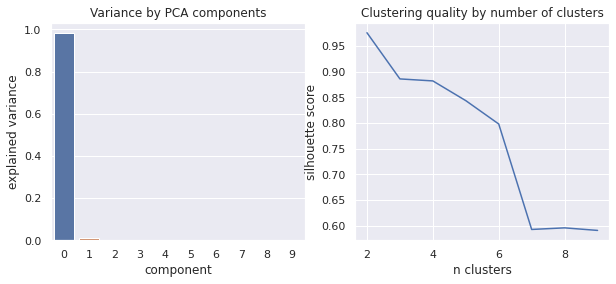

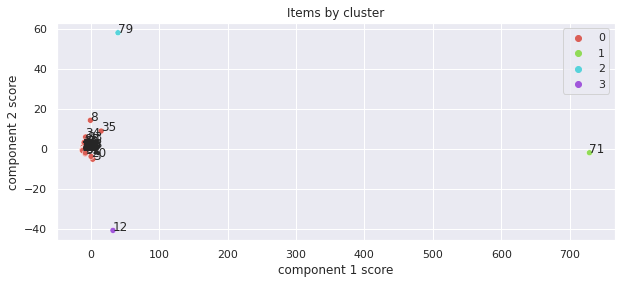

In [22]:
category_group_dict = cluster_feature(matrix, 'item_cnt_month', 'item_category_id', 'date_block_num', n_components=2, n_clusters=4, aggfunc="mean", exclude =[])
matrix['category_cluster'] = matrix['item_category_id'].map(category_group_dict)

Shops are clustered by their summed sales of each item category. The principle component plots show that shops mainly differ in the magnitude of their sales, with shop 31 being an outlier due to the volume of its sales. Shops 12 and 55 are outliers on an orthogonal dimension because they sell different (online only) items.

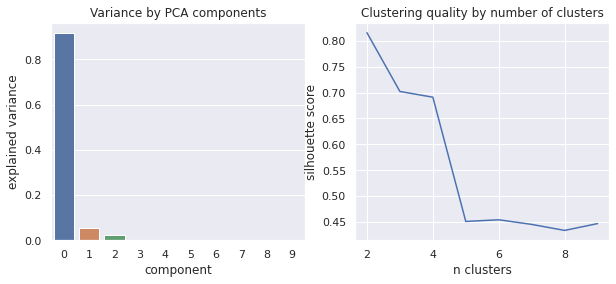

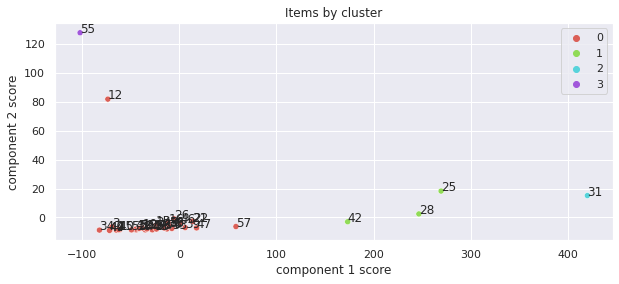

In [23]:
shop_group_dict = cluster_feature(matrix, 'item_cnt_month', 'shop_id', 'item_category_id', n_components=4, n_clusters=4, aggfunc="mean", exclude=[36])
shop_group_dict[36] = shop_group_dict[37]  # Shop36 added separately because it only has one month of data
matrix['shop_cluster'] = matrix['shop_id'].map(shop_group_dict)

In [24]:
gc.collect()
matrix, oldcols = shrink_mem_new_cols(matrix, oldcols)  # Use this function periodically to downcast dtypes to save memory

# Number of unique item features

These features count the number of unique items sharing the same value of a grouping feature or set of features as the current item in the current month, e.g. number of new items in the same category.  

This could considered to be a kind of data leakage feature, as the set of items in each month (and therefore the test set) is determined by whether each item recorded a sale or not in the month being predicted, which isn't known in advance.

In [25]:
def uniques(matrix, groupers, name, limitation=None):
    if limitation is not None:
        s = (
            matrix.query(limitation)
            .groupby(groupers)
            .item_id.nunique()
            .rename(name)
            .reset_index()
        )
    else:
        s = matrix.groupby(groupers).item_id.nunique().rename(name).reset_index()
    matrix = matrix.merge(s, on=groupers, how="left")
    matrix[name] = matrix[name].fillna(0)
    return matrix


matrix = uniques(matrix, ["date_block_num"], "unique_items_month")

matrix = uniques(matrix, ["date_block_num", "item_name_group"], "name_group_unique_month")
matrix = uniques(
    matrix,
    ["date_block_num", "item_category_id", "item_name_group"],
    "name_group_cat_unique_month",
)
matrix = uniques(
    matrix,
    ["date_block_num", "item_name_group"],
    "name_group_new_unique_month",
    limitation="new_item==True",
)
matrix = uniques(
    matrix,
    ["date_block_num", "item_category_id", "item_name_group"],
    "name_group_new_cat_unique_month",
    limitation="new_item==True",
)

matrix = uniques(
    matrix, ["date_block_num", "artist_name_or_first_word"], "first_word_unique_month"
)
matrix = uniques(
    matrix,
    ["date_block_num", "item_category_id", "artist_name_or_first_word"],
    "first_word_cat_unique_month",
)
matrix = uniques(
    matrix,
    ["date_block_num", "artist_name_or_first_word"],
    "first_word_new_unique_month",
    limitation="new_item==True",
)
matrix = uniques(
    matrix,
    ["date_block_num", "item_category_id", "artist_name_or_first_word"],
    "first_word_new_cat_unique_month",
    limitation="new_item==True",
)

matrix = uniques(matrix, ["date_block_num", "item_category_id"], "unique_items_cat")
matrix = uniques(
    matrix,
    ["date_block_num", "item_category_id"],
    "new_items_cat",
    limitation="new_item==True",
)
matrix = uniques(matrix, ["date_block_num"], "new_items_month", limitation="new_item==True")

matrix["cat_items_proportion"] = matrix["unique_items_cat"] / matrix["unique_items_month"]
matrix["name_group_new_proportion_month"] = (
    matrix["name_group_new_unique_month"] / matrix["name_group_unique_month"]
)

matrix = matrix.drop(columns=["unique_items_month", "name_group_unique_month"])

In [26]:
matrix, oldcols = shrink_mem_new_cols(matrix, oldcols)

# Percentage change in an aggregate feature  
This uses the pandas pct_change method to calculate the proportional change in mean sales count for a specific grouping for a specific time interval, e.g. increase / decrease in mean sales of an item between the last 2 months.

In [27]:
def add_pct_change(
    matrix,
    group_feats,
    target="item_cnt_month",
    aggfunc="mean",
    periods=1,
    lag=1,
    clip_value=None,
):
    periods = list_if_not(periods, int)
    group_feats = list_if_not(group_feats)
    group_feats_full = ["date_block_num"] + group_feats
    dat = matrix.pivot_table(
        index=group_feats + ["date_block_num"],
        values=target,
        aggfunc=aggfunc,
        fill_value=0,
        dropna=False,
    ).astype("float32")
    for g in group_feats:
        firsts = matrix.groupby(g).date_block_num.min().rename("firsts")
        dat = dat.merge(firsts, left_on=g, right_index=True, how="left")
        dat.loc[dat.index.get_level_values("date_block_num") < dat["firsts"], target] = float(
            "nan"
        )
        del dat["firsts"]
    for period in periods:
        feat_name = "_".join(
            group_feats + [target] + [aggfunc] + ["delta"] + [str(period)] + [f"lag_{lag}"]
        )
        print(f"Adding feature {feat_name}")
        dat = (
            dat.groupby(group_feats)[target]
            .transform(lambda x: x.pct_change(periods=period, fill_method="pad"))
            .rename(feat_name)
        )
        if clip_value is not None:
            dat = dat.clip(lower=-clip_value, upper=clip_value)
    dat = dat.reset_index()
    dat["date_block_num"] += lag
    matrix = matrix.merge(dat, on=["date_block_num"] + group_feats, how="left")
    matrix[feat_name] = reduce_mem_usage(matrix[feat_name])
    return matrix

In [28]:
matrix = add_pct_change(matrix, ["item_id"], "item_cnt_month", clip_value=3)
matrix = add_pct_change(matrix, ["item_category_id"], "item_cnt_month", clip_value=3)
matrix = add_pct_change(matrix, ["item_name_group"], "item_cnt_month", clip_value=3)
# Delta 1 feature lagged by 12 months, intended to capture seasonal trends
matrix = add_pct_change(matrix, ["item_category_id"], "item_cnt_month", lag=12, clip_value=3,)
gc.collect()

Adding feature item_id_item_cnt_month_mean_delta_1_lag_1
Adding feature item_category_id_item_cnt_month_mean_delta_1_lag_1
Adding feature item_name_group_item_cnt_month_mean_delta_1_lag_1
Adding feature item_category_id_item_cnt_month_mean_delta_1_lag_12


5

In [29]:
matrix, oldcols = shrink_mem_new_cols(matrix, oldcols)

# Windowed aggregates

Features aggregated over a specific window to reduce noise. Available windows are expanding (i.e. all preceding timepoints), rolling (i.e. fixed number of equally weighted timepoints) and exponentially weighted mean.  


A note about feature names: these are set automatically according to the pattern < grouping features > - < aggregated features > - < monthly aggregation function > - < window type > , where < window type > is either "rolling - < window aggregation function > - win - < window length in months >" for square rolling windows, "expanding - < window aggregation function >" for expanding windows, and "ewm_hl - < decay rate in terms of half-life > for exponential weighted means, all connected by underscores.

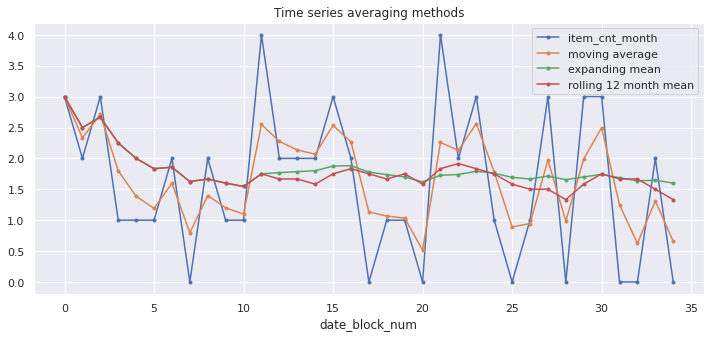

In [30]:
shop_id = 16
item_id = 482
im = matrix.query(f"shop_id=={shop_id} & item_id=={item_id}")[['date_block_num', 'item_cnt_month']]
im['moving average'] = im['item_cnt_month'].ewm(halflife=1).mean()
im['expanding mean'] = im['item_cnt_month'].expanding().mean()
im['rolling 12 month mean'] = im['item_cnt_month'].rolling(window=12, min_periods=1).mean()
im = im.set_index('date_block_num')
ax = im.plot(figsize=(12,5), marker='.', title='Time series averaging methods')

In [31]:
def add_rolling_stats(
    matrix,
    features,
    window=12,
    kind="rolling",
    argfeat="item_cnt_month",
    aggfunc="mean",
    rolling_aggfunc="mean",
    dtype="float16",
    reshape_source=True,
    lag_offset=0,
):
    def rolling_stat(
        matrix,
        source,
        feats,
        feat_name,
        window=12,
        argfeat="item_cnt_month",
        aggfunc="mean",
        dtype=dtype,
        lag_offset=0,
    ):
        # Calculate a statistic on a windowed section of a source table,  grouping on specific features
        store = []
        for i in range(2 + lag_offset, 35 + lag_offset):
            if len(feats) > 0:
                mes = (
                    source[source.date_block_num.isin(range(max([i - window, 0]), i))]
                    .groupby(feats)[argfeat]
                    .agg(aggfunc)
                    .astype(dtype)
                    .rename(feat_name)
                    .reset_index()
                )
            else:
                mes = {}
                mes[feat_name] = (
                    source.loc[
                        source.date_block_num.isin(range(max([i - window, 0]), i)), argfeat
                    ]
                    .agg(aggfunc)
                    .astype(dtype)
                )
                mes = pd.DataFrame(data=mes, index=[i])
            mes["date_block_num"] = i - lag_offset
            store.append(mes)
        store = pd.concat(store)
        matrix = matrix.merge(store, on=feats + ["date_block_num"], how="left")
        return matrix

    """ An issue when using windowed functions is that missing values from months when items recorded no sales are skipped rather than being correctly
    treated as zeroes. Creating a pivot_table fills in the zeros."""
    if (reshape_source == True) or (kind == "ewm"):
        source = matrix.pivot_table(
            index=features + ["date_block_num"],
            values=argfeat,
            aggfunc=aggfunc,
            fill_value=0,
            dropna=False,
        ).astype(dtype)
        for g in features:
            firsts = matrix.groupby(g).date_block_num.min().rename("firsts")
            source = source.merge(firsts, left_on=g, right_index=True, how="left")
            # Set values before the items first appearance to nan so they are ignored rather than being treated as zero sales.
            source.loc[
                source.index.get_level_values("date_block_num") < source["firsts"], argfeat
            ] = float("nan")
            del source["firsts"]
        source = source.reset_index()
    else:
        source = matrix

    if kind == "rolling":
        feat_name = (
            f"{'_'.join(features)}_{argfeat}_{aggfunc}_rolling_{rolling_aggfunc}_win_{window}"
        )
        print(f'Creating feature "{feat_name}"')
        return rolling_stat(
            matrix,
            source,
            features,
            feat_name,
            window=window,
            argfeat=argfeat,
            aggfunc=rolling_aggfunc,
            dtype=dtype,
            lag_offset=lag_offset,
        )
    elif kind == "expanding":
        feat_name = f"{'_'.join(features)}_{argfeat}_{aggfunc}_expanding_{rolling_aggfunc}"
        print(f'Creating feature "{feat_name}"')
        return rolling_stat(
            matrix,
            source,
            features,
            feat_name,
            window=100,
            argfeat=argfeat,
            aggfunc=aggfunc,
            dtype=dtype,
            lag_offset=lag_offset,
        )
    elif kind == "ewm":
        feat_name = f"{'_'.join(features)}_{argfeat}_{aggfunc}_ewm_hl_{window}"
        print(f'Creating feature "{feat_name}"')
        source[feat_name] = (
            source.groupby(features)[argfeat]
            .ewm(halflife=window, min_periods=1)
            .agg(rolling_aggfunc)
            .to_numpy(dtype=dtype)
        )
        del source[argfeat]
        #         source = source.reset_index()
        source["date_block_num"] += 1 - lag_offset
        return matrix.merge(source, on=["date_block_num"] + features, how="left")

Create rolling mean features. The combinations of grouping features and window types here were selected by generating a large number of features and then pruning them with the scikit-learn RFECV function.

In [32]:
matrix = add_rolling_stats(
    matrix,
    ["shop_id", "artist_name_or_first_word", "item_category_id", "item_age"],
    window=12,
    reshape_source=False,
)
matrix = add_rolling_stats(
    matrix,
    ["shop_id", "artist_name_or_first_word", "item_category_id", "new_item"],
    kind="expanding",
    reshape_source=False,
)
matrix = add_rolling_stats(
    matrix,
    ["shop_id", "artist_name_or_first_word", "new_item"],
    kind="expanding",
    reshape_source=False,
)
matrix = add_rolling_stats(matrix, ["shop_id", "category_cluster"], window=12)
matrix = add_rolling_stats(
    matrix,
    ["shop_id", "item_category_id", "item_age"],
    kind="expanding",
    reshape_source=False,
)
matrix = add_rolling_stats(
    matrix, ["shop_id", "item_category_id", "item_age"], window=12, reshape_source=False
)
matrix = add_rolling_stats(matrix, ["shop_id", "item_category_id"], kind="ewm", window=1)
matrix = add_rolling_stats(
    matrix,
    ["shop_id", "item_category_id", "new_item"],
    kind="expanding",
    reshape_source=False,
)
matrix = add_rolling_stats(
    matrix, ["shop_id", "item_category_id", "new_item"], window=12, reshape_source=False
)
matrix = add_rolling_stats(matrix, ["shop_id"], window=12)
matrix = add_rolling_stats(matrix, ["shop_id", "item_id"], kind="ewm", window=1)
matrix = add_rolling_stats(matrix, ["shop_id", "item_id"], window=12)
matrix = add_rolling_stats(
    matrix,
    ["shop_id", "item_name_group", "item_category_id", "new_item"],
    window=12,
    reshape_source=False,
)
matrix = add_rolling_stats(
    matrix, ["shop_id", "item_name_group", "new_item"], kind="expanding", reshape_source=False
)
matrix = add_rolling_stats(
    matrix, ["shop_id", "supercategory_id", "new_item"], window=12, reshape_source=False
)

matrix = add_rolling_stats(matrix, ["shop_cluster", "item_id"], kind="ewm", window=1)
matrix = add_rolling_stats(
    matrix,
    ["shop_cluster", "item_category_id", "item_age"],
    kind="expanding",
    reshape_source=False,
)
matrix = add_rolling_stats(
    matrix, ["shop_cluster", "item_name_group", "new_item"], window=12, reshape_source=False
)

matrix = add_rolling_stats(
    matrix, ["category_cluster", "item_age"], kind="expanding", reshape_source=False
)
matrix = add_rolling_stats(
    matrix, ["category_cluster", "new_item"], kind="expanding", reshape_source=False
)

matrix = add_rolling_stats(matrix, ["item_id"], window=12)

matrix = add_rolling_stats(matrix, ["artist_name_or_first_word"], window=12)
matrix = add_rolling_stats(matrix, ["artist_name_or_first_word"], kind="ewm", window=1)
matrix = add_rolling_stats(
    matrix, ["artist_name_or_first_word", "item_age"], window=12, reshape_source=False
)
matrix = add_rolling_stats(
    matrix,
    ["artist_name_or_first_word", "item_category_id", "item_age"],
    window=12,
    reshape_source=False,
)
matrix = add_rolling_stats(
    matrix, ["artist_name_or_first_word", "new_item"], kind="expanding", reshape_source=False
)

matrix = add_rolling_stats(
    matrix, ["item_category_id", "item_age"], kind="expanding", reshape_source=False
)
matrix = add_rolling_stats(matrix, ["item_category_id"], window=12)
matrix = add_rolling_stats(matrix, ["item_category_id"], kind="ewm", window=1)
matrix = add_rolling_stats(
    matrix, ["item_category_id", "new_item"], kind="expanding", reshape_source=False
)

matrix = add_rolling_stats(
    matrix, ["item_name_group", "item_age"], window=12, reshape_source=False
)
matrix = add_rolling_stats(matrix, ["item_name_group"], kind="ewm", window=1)
matrix = add_rolling_stats(matrix, ["item_name_group"], window=12)

matrix = add_rolling_stats(matrix, ["platform_id"], window=12)
matrix = add_rolling_stats(matrix, ["platform_id"], kind="ewm", window=1)

Creating feature "shop_id_artist_name_or_first_word_item_category_id_item_age_item_cnt_month_mean_rolling_mean_win_12"
Creating feature "shop_id_artist_name_or_first_word_item_category_id_new_item_item_cnt_month_mean_expanding_mean"
Creating feature "shop_id_artist_name_or_first_word_new_item_item_cnt_month_mean_expanding_mean"
Creating feature "shop_id_category_cluster_item_cnt_month_mean_rolling_mean_win_12"
Creating feature "shop_id_item_category_id_item_age_item_cnt_month_mean_expanding_mean"
Creating feature "shop_id_item_category_id_item_age_item_cnt_month_mean_rolling_mean_win_12"
Creating feature "shop_id_item_category_id_item_cnt_month_mean_ewm_hl_1"
Creating feature "shop_id_item_category_id_new_item_item_cnt_month_mean_expanding_mean"
Creating feature "shop_id_item_category_id_new_item_item_cnt_month_mean_rolling_mean_win_12"
Creating feature "shop_id_item_cnt_month_mean_rolling_mean_win_12"
Creating feature "shop_id_item_id_item_cnt_month_mean_ewm_hl_1"
Creating feature "sh

In [33]:
gc.collect()
matrix, oldcols = shrink_mem_new_cols(matrix, oldcols)

matrix.to_pickle("matrixcheckpoint1.pkl")
print("Saved matrixcheckpoint")
gc.collect()

print("Widnow aggregate features created")

Saved matrixcheckpoint
Widnow aggregate features created


The following code block calculates windowed mean sales features with day resolution accuracy

In [35]:
# Summed sales & accurate windowed mean sales per day features
matrix = add_rolling_stats(
    matrix,
    ["shop_id", "item_id"],
    aggfunc="sum",
    rolling_aggfunc="sum",
    kind="rolling",
    window=12,
    reshape_source=False,
)
matrix = add_rolling_stats(
    matrix,
    ["item_id"],
    aggfunc="sum",
    rolling_aggfunc="sum",
    kind="expanding",
    reshape_source=False,
)
matrix["1year"] = 365
matrix["item_id_day_mean_expanding"] = matrix[
    "item_id_item_cnt_month_sum_expanding_sum"
] / matrix[["first_item_sale_days"]].min(axis=1)
matrix["shop_id_item_id_day_mean_win_12"] = matrix[
    "shop_id_item_id_item_cnt_month_sum_rolling_sum_win_12"
] / matrix[["first_item_sale_days", "shop_open_days", "1year"]].min(axis=1)
matrix.loc[matrix.new_item == True, "item_id_day_mean_expanding",] = float("nan")
matrix = matrix.drop(columns=["1year", "item_id_item_cnt_month_sum_expanding_sum"])

Creating feature "shop_id_item_id_item_cnt_month_sum_rolling_sum_win_12"
Creating feature "item_id_item_cnt_month_sum_expanding_sum"


Revenue features

In [36]:
matrix = add_rolling_stats(
    matrix,
    ["shop_id", "item_name_group"],
    window=12,
    argfeat="item_revenue_month",
    dtype="float32",
)

Creating feature "shop_id_item_name_group_item_revenue_month_mean_rolling_mean_win_12"


Windowed mean unique item features and ratio of new items in category with mean over the previous year

In [37]:
matrix = add_rolling_stats(
    matrix,
    ["item_category_id"],
    argfeat="new_items_cat",
    window=12,
    reshape_source=True,
    lag_offset=1,
)
matrix = add_rolling_stats(
    matrix,
    ["item_name_group"],
    argfeat="name_group_new_unique_month",
    window=12,
    reshape_source=True,
    lag_offset=1,
)

matrix["new_items_cat_1_12_ratio"] = (
    matrix["new_items_cat"]
    / matrix["item_category_id_new_items_cat_mean_rolling_mean_win_12"]
)

Creating feature "item_category_id_new_items_cat_mean_rolling_mean_win_12"
Creating feature "item_name_group_name_group_new_unique_month_mean_rolling_mean_win_12"


In [38]:
gc.collect()
matrix, oldcols = shrink_mem_new_cols(matrix, oldcols)

# Lagged features and mean encodings  
Values for the same shop-item combination from previous months

In [39]:
def simple_lag_feature(matrix, lag_feature, lags):
    for lag in lags:
        newname = lag_feature + f"_lag_{lag}"
        print(f"Adding feature {newname}")
        targetseries = matrix.loc[:, ["date_block_num", "item_id", "shop_id"] + [lag_feature]]
        targetseries["date_block_num"] += lag
        targetseries = targetseries.rename(columns={lag_feature: newname})
        matrix = matrix.merge(
            targetseries, on=["date_block_num", "item_id", "shop_id"], how="left"
        )
        matrix.loc[
            (matrix.item_age >= lag) & (matrix.shop_age >= lag) & (matrix[newname].isna()),
            newname,
        ] = 0
    return matrix

In [40]:
matrix = simple_lag_feature(matrix, 'item_cnt_month', lags=[1, 2, 3])
matrix = simple_lag_feature(matrix, 'item_cnt_day_avg', lags=[1, 2, 3])
matrix = simple_lag_feature(matrix, 'item_revenue_month', lags=[1])
gc.collect()
print("Lag features created")

Adding feature item_cnt_month_lag_1
Adding feature item_cnt_month_lag_2
Adding feature item_cnt_month_lag_3
Adding feature item_cnt_month_lag_4
Adding feature item_cnt_month_lag_5
Adding feature item_cnt_month_lag_6
Adding feature item_cnt_month_lag_12
Adding feature item_cnt_day_avg_lag_1
Adding feature item_cnt_day_avg_lag_2
Adding feature item_cnt_day_avg_lag_3
Adding feature item_cnt_day_avg_lag_4
Adding feature item_cnt_day_avg_lag_5
Adding feature item_cnt_day_avg_lag_6
Adding feature item_cnt_day_avg_lag_12
Adding feature item_revenue_month_lag_1
Lag features created


## Mean encodings
The mean or sum value of a target feature for each level of a categorical feature or combination of categorical features, lagged

In [41]:
def create_apply_ME(
    matrix, grouping_fields, lags=[1], target="item_cnt_day_avg", aggfunc="mean"
):
    grouping_fields = list_if_not(grouping_fields)
    for lag in lags:
        newname = "_".join(grouping_fields + [target] + [aggfunc] + [f"lag_{lag}"])
        print(f"Adding feature {newname}")
        me_series = (
            matrix.groupby(["date_block_num"] + grouping_fields)[target]
            .agg(aggfunc)
            .rename(newname)
            .reset_index()
        )
        me_series["date_block_num"] += lag
        matrix = matrix.merge(me_series, on=["date_block_num"] + grouping_fields, how="left")
        del me_series
        matrix[newname] = matrix[newname].fillna(0)
        for g in grouping_fields:
            firsts = matrix.groupby(g).date_block_num.min().rename("firsts")
            matrix = matrix.merge(firsts, left_on=g, right_index=True, how="left")
            matrix.loc[
                matrix["date_block_num"] < (matrix["firsts"] + (lag)), newname
            ] = float("nan")
            del matrix["firsts"]
        matrix[newname] = reduce_mem_usage(matrix[newname])
    return matrix

In [42]:
matrix = create_apply_ME(matrix, ["item_name_group"], target="item_cnt_month")
matrix = create_apply_ME(matrix, ["item_name_group"], target="item_cnt_month", aggfunc="sum")
matrix = create_apply_ME(matrix, ["item_id"], target="item_cnt_month")
matrix = create_apply_ME(matrix, ["item_id"])
matrix = create_apply_ME(matrix, ["platform_id"])
matrix = create_apply_ME(matrix, ["item_name_group"])
matrix = create_apply_ME(matrix, ["platform_id"], target="item_cnt_month")
matrix = create_apply_ME(matrix, ["supercategory_id"])
matrix = create_apply_ME(matrix, ["item_category_id", "new_item"], target="item_cnt_month")
matrix = create_apply_ME(matrix, ["shop_id", "item_category_id"], target="item_cnt_month")
matrix = create_apply_ME(matrix, ["shop_cluster", "item_id"], target="item_cnt_month")
matrix = create_apply_ME(matrix, ["shop_cluster", "item_id"])
matrix = create_apply_ME(matrix, ["city_code", "item_id"])
matrix = create_apply_ME(matrix, ["city_code", "item_name_group"])
matrix = create_apply_ME(matrix, ["shop_type", "item_id"])
matrix = create_apply_ME(matrix, ["shop_type", "item_id"], target="item_cnt_month")

Adding feature item_name_group_item_cnt_month_mean_lag_1
Adding feature item_name_group_item_cnt_month_sum_lag_1
Adding feature item_id_item_cnt_month_mean_lag_1
Adding feature item_id_item_cnt_day_avg_mean_lag_1
Adding feature platform_id_item_cnt_day_avg_mean_lag_1
Adding feature item_name_group_item_cnt_day_avg_mean_lag_1
Adding feature platform_id_item_cnt_month_mean_lag_1
Adding feature supercategory_id_item_cnt_day_avg_mean_lag_1
Adding feature item_category_id_new_item_item_cnt_month_mean_lag_1
Adding feature shop_id_item_category_id_item_cnt_month_mean_lag_1
Adding feature shop_cluster_item_id_item_cnt_month_mean_lag_1
Adding feature shop_cluster_item_id_item_cnt_day_avg_mean_lag_1
Adding feature city_code_item_id_item_cnt_day_avg_mean_lag_1
Adding feature city_code_item_name_group_item_cnt_day_avg_mean_lag_1
Adding feature shop_type_item_id_item_cnt_day_avg_mean_lag_1
Adding feature shop_type_item_id_item_cnt_month_mean_lag_1


Ratios between lag 1 sales and rolling 12 month means, to capture decreases from previous means

In [43]:
matrix["item_id_item_cnt_1_12_ratio"] = (
    matrix["item_id_item_cnt_month_mean_lag_1"]
    / matrix["item_id_item_cnt_month_mean_rolling_mean_win_12"]
)
matrix["shop_id_item_id_item_cnt_1_12_ratio"] = (
    matrix["item_cnt_day_avg_lag_1"] / matrix["shop_id_item_id_day_mean_win_12"]
)

In [44]:
matrix, oldcols = shrink_mem_new_cols(matrix, oldcols)
matrix.to_pickle("matrixcheckpoint2.pkl")
print("Saved matrixcheckpoint")
gc.collect()
print("Mean encoding features created")

Saved matrixcheckpoint
Mean encoding features created


Some columns that were used to generate other features can now be discarded.

In [45]:
surplus_columns = [
    "item_revenue_month",
    "item_cnt_day_avg",
    "item_name_group",
    "artist_name_or_first_word",
    "item_age",
    "shop_open_days",
    "shop_age",
    "platform_id",
    "supercategory_id",
    "city_code",
    "category_cluster",
    "shop_cluster",
    "shop_type",
    "new_items_cat",
    "shop_id_item_id_day_mean_win_12",
    "item_id_item_cnt_month_mean_rolling_mean_win_12",
]
matrix = matrix.drop(columns=surplus_columns)

# Predictive words in item_name

One-hot features are made for words in the item_name field that are predictive of item sales.  

To select *k* word features from the 1000's of words found in item names, words are discarded if they are not in the names of a threshold number of items, or are not in the names of new items in the test or validation months. Remaining words are then selected by the scikit-learn SelectKBest function according to their correlation with the target.

In [46]:
import re
import warnings

warnings.filterwarnings("ignore", module="sklearn")

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest, f_regression


def name_token_feats(matrix, items, k=50, item_n_threshold=5, target_month_start=33):
    def name_correction(st):
        st = re.sub(r"[^\w\s]", "", st)
        st = re.sub(r"\s{2,}", " ", st)
        st = st.lower().strip()
        return st

    items["item_name_clean"] = items["item_name"].apply(name_correction)

    def create_item_id_bow_matrix(items):
        all_stopwords = stopwords.words("russian")
        all_stopwords = all_stopwords + stopwords.words("english")

        vectorizer = CountVectorizer(stop_words=all_stopwords)
        X = vectorizer.fit_transform(items.loc[:, "item_name_clean"])
        X = pd.DataFrame.sparse.from_spmatrix(X)
        print(f"{len(vectorizer.vocabulary_)} words found in all items")
        featuremap = {
            col: "word_" + token
            for col, token in zip(
                range(len(vectorizer.vocabulary_)), vectorizer.get_feature_names()
            )
        }
        X = X.rename(columns=featuremap)
        return X

    items_bow = create_item_id_bow_matrix(items)
    items_bow = items_bow.clip(0, 1)  # Made the word counts binary
    common_word_mask = items_bow.sum(axis=0) > item_n_threshold
    target_items = matrix.query(
        f"date_block_num>={target_month_start} & new_item==True"
    ).item_id.unique()
    target_item_mask = items_bow.loc[target_items, :].sum(axis=0) > 1
    items_bow = items_bow.loc[:, common_word_mask & target_item_mask]
    print(f"{items_bow.shape[1]} words of interest")
    mxbow = matrix[["date_block_num", "item_id", "item_cnt_month"]].query("date_block_num<34")
    mxbow = mxbow.merge(items_bow, left_on="item_id", right_index=True, how="left")
    X = mxbow.drop(columns=["date_block_num", "item_id", "item_cnt_month"])
    y = mxbow["item_cnt_month"].clip(0, 20)
    selektor = SelectKBest(f_regression, k=k)
    selektor.fit(X, y)
    tokencols = X.columns[selektor.get_support()]
    print(f"{k} word features selected")
    return items_bow[tokencols]

In [47]:
items = pd.read_csv("items.csv.zip")
word_frame = name_token_feats(matrix, items, k=50, item_n_threshold=5)
matrix = matrix.merge(word_frame, left_on='item_id', right_index=True, how='left')
# LightGBM didn't seem to work with sparse features in this case, so we'll convert them to int
sparsecols = [c for c in matrix.columns if pd.api.types.is_sparse(matrix[c].dtype)]
matrix[sparsecols] = matrix[sparsecols].sparse.to_dense().astype('int8')

19134 words found in all items
449 words of interest
50 word features selected


The final feature frame is saved and the notebook kernel is reset to free up memory for LightGBM.

In [48]:
gc.collect()
matrix.to_pickle("checkpoint_final.pkl")
print("All features generated, dataframe saved")

All features generated, dataframe saved


In [ ]:
%reset -f

# Model fitting

In [3]:
import os
import gc
import numpy as np
import pandas as pd
import multiprocessing as mp
from tqdm.notebook import tqdm as tqdm_notebook
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from catboost import CatBoostRegressor

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

The feature frame is loaded and the target is clipped to match the test items

In [4]:
matrix = pd.read_pickle("checkpoint_final.pkl")
matrix['item_cnt_month'] = matrix['item_cnt_month'].clip(0,20)
# drop first 2 months
matrix = matrix[matrix.date_block_num >= 2]

In [5]:
cols = [c for c in matrix.columns if c.endswith('lag_4') or c.endswith('lag_5') or c.endswith('lag_6') or c.endswith('lag_12')]
matrix = matrix.drop(cols, axis=1)

### Optimize the model with Optuna

In [6]:
import optuna
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

cat_feats = ['item_category_id', 'month', 'season']

last_block = 33
dates = matrix['date_block_num']

# drop target and some features that lead to overfitting
cols_to_drop = ['item_cnt_month', 'new_item', 'shop_id', 'item_id']

# split dataset on train and test sets for model training
X_train = matrix.loc[dates <  last_block].drop(cols_to_drop, axis=1)
X_val = matrix.loc[dates ==  last_block].drop(cols_to_drop, axis=1)
X_test = matrix.loc[dates ==  34].drop(cols_to_drop, axis=1)

y_train = matrix.loc[dates <  last_block, 'item_cnt_month']
y_val = matrix.loc[dates ==  last_block, 'item_cnt_month']


def objective(trial):
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_val, label=y_val)

    param = {
        "objective": "mse",
        "metric": "rmse",
        "verbosity": 1,
        "boosting_type": "gbdt",
        "device": "gpu",
        "gpu_platform_id": 0,
        "gpu_device_id": 0,
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 1024),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    # Add a callback for pruning.
    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "auc")
    gbm = lgb.train(
            param, 
            dtrain, 
            valid_sets=[dvalid], 
            verbose_eval=100,
            categorical_feature=cat_feats,
            callbacks=[pruning_callback]
    )

    preds = gbm.predict(valid_x)
    accuracy = mean_squared_error(valid_y, preds, squared=False)
    return accuracy

study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=10), direction="minimize")
study.optimize(objective, n_trials=100)

[I 2021-08-26 09:24:34,429] A new study created in memory with name: no-name-aab13a04-f1e2-4061-aacc-021e4e10a88f
/home/alex/.local/lib/python3.8/site-packages/lightgbm/basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['item_category_id', 'month', 'season']
  _log_warning('categorical_feature in Dataset is overridden.\n'
[W 2021-08-26 09:24:44,330] Trial 0 failed because of the following error: LightGBMError('GPU Tree Learner was not enabled in this build.\nPlease recompile with CMake option -DUSE_GPU=1')
Traceback (most recent call last):
  File "/home/alex/.local/lib/python3.8/site-packages/optuna/_optimize.py", line 217, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-6-39da7385a387>", line 45, in objective
    gbm = lgb.train(
  File "/home/alex/.local/lib/python3.8/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/home/alex/.local/lib/py

LightGBMError: GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1

In [5]:
import optuna
import optuna.integration.lightgbm as lgb

params = {
    'objective': 'mse',
    'metric': 'rmse',
    'verbose': 1,
    'device': 'gpu',
    'gpu_platform_id': 0,
    'gpu_device_id': 0
}
cat_feats = ['item_category_id', 'month']

last_block = 33
dates = matrix['date_block_num']

# drop target and some features that lead to overfitting
cols_to_drop = ['item_cnt_month', 'new_item', 'shop_id', 'item_id']

# split dataset on train and test sets for model training
X_train = matrix.loc[dates <  last_block].drop(cols_to_drop, axis=1)
X_val = matrix.loc[dates ==  last_block].drop(cols_to_drop, axis=1)
X_test = matrix.loc[dates ==  34].drop(cols_to_drop, axis=1)

y_train = matrix.loc[dates <  last_block, 'item_cnt_month']
y_val = matrix.loc[dates ==  last_block, 'item_cnt_month']

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

study = optuna.create_study()

gbm = lgb.train(
        params,
        lgb_train,
        num_boost_round=8000,
        study = study,
        valid_sets=(lgb_train, lgb_eval), 
#         valid_sets=lgb_train,
        categorical_feature = cat_feats,
        verbose_eval=50, 
        early_stopping_rounds = 30,
)

[I 2021-08-25 17:12:54,485] A new study created in memory with name: no-name-fd1b473f-b78c-48a3-8132-fe2dc09b2a02
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/alex/.local/lib/python3.8/site-packages/lightgbm/basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['item_category_id', 'month']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 3.274649 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19476
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 142


/home/alex/.local/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/alex/.local/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.798105	valid_1's rmse: 0.733762
[100]	valid_0's rmse: 0.762576	valid_1's rmse: 0.725243
[150]	valid_0's rmse: 0.744603	valid_1's rmse: 0.722851


feature_fraction, val_score: 0.722520:  14%|#4        | 1/7 [01:11<07:09, 71.66s/it]

Early stopping, best iteration is:
[132]	valid_0's rmse: 0.750048	valid_1's rmse: 0.72252
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 3.115005 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19476
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 142
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.796111	valid_1's rmse: 0.725757
[100]	valid_0's rmse: 0.760568	valid_1's rmse: 0.718284


feature_fraction, val_score: 0.716324:  29%|##8       | 2/7 [02:25<06:05, 73.13s/it]

[150]	valid_0's rmse: 0.742507	valid_1's rmse: 0.717427
Early stopping, best iteration is:
[120]	valid_0's rmse: 0.752642	valid_1's rmse: 0.716324
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.746155 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19476
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 142
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.799719	valid_1's rmse: 0.737689
[100]	valid_0's rmse: 0.764008	valid_1's rmse: 0.728674
[150]	valid_0's rmse: 0.747203	valid_1's rmse: 0.726075
[200]	valid_0's rmse: 0.732963	valid_1's rmse: 0.724687


feature_fraction, val_score: 0.716324:  43%|####2     | 3/7 [04:40<06:45, 101.27s/it]

Early stopping, best iteration is:
[174]	valid_0's rmse: 0.740226	valid_1's rmse: 0.723806
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 2.920068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19476
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 142
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.794801	valid_1's rmse: 0.737693
[100]	valid_0's rmse: 0.758048	valid_1's rmse: 0.726255
[150]	valid_0's rmse: 0.739488	valid_1's rmse: 0.721431
[200]	valid_0's rmse: 0.727625	valid_1's rmse: 0.719407
[250]	valid_0's rmse: 0.717665	valid_1's rmse: 0.716391
[300]	valid_0's rmse: 0.708793	valid_1's rmse: 0.716608


feature_fraction, val_score: 0.716119:  57%|#####7    | 4/7 [07:00<05:49, 116.62s/it]

Early stopping, best iteration is:
[285]	valid_0's rmse: 0.711047	valid_1's rmse: 0.716119
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 2.955024 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19476
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 142
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.796388	valid_1's rmse: 0.732485
[100]	valid_0's rmse: 0.759887	valid_1's rmse: 0.723478
[150]	valid_0's rmse: 0.74259	valid_1's rmse: 0.716907


feature_fraction, val_score: 0.716119:  71%|#######1  | 5/7 [08:25<03:30, 105.23s/it]

Early stopping, best iteration is:
[159]	valid_0's rmse: 0.740447	valid_1's rmse: 0.716652
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.674447 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19476
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 142
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.799881	valid_1's rmse: 0.735611
[100]	valid_0's rmse: 0.765337	valid_1's rmse: 0.724427
[150]	valid_0's rmse: 0.746924	valid_1's rmse: 0.720455
[200]	valid_0's rmse: 0.733742	valid_1's rmse: 0.719232


feature_fraction, val_score: 0.716119:  86%|########5 | 6/7 [10:27<01:50, 110.87s/it]

Early stopping, best iteration is:
[186]	valid_0's rmse: 0.736706	valid_1's rmse: 0.717912
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 3.015042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19476
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 142
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.795921	valid_1's rmse: 0.734002
[100]	valid_0's rmse: 0.759654	valid_1's rmse: 0.721174
[150]	valid_0's rmse: 0.742048	valid_1's rmse: 0.71559
[200]	valid_0's rmse: 0.728548	valid_1's rmse: 0.714982
[250]	valid_0's rmse: 0.718967	valid_1's rmse: 0.715582


num_leaves, val_score: 0.714232:   0%|          | 0/20 [00:00<?, ?it/s]

Early stopping, best iteration is:
[223]	valid_0's rmse: 0.723885	valid_1's rmse: 0.714232
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 2.994559 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19476
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 142
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.748124	valid_1's rmse: 0.717818
[100]	valid_0's rmse: 0.711551	valid_1's rmse: 0.711098
[150]	valid_0's rmse: 0.6929	valid_1's rmse: 0.711705


num_leaves, val_score: 0.710559:   5%|5         | 1/20 [01:30<28:46, 90.86s/it]

Early stopping, best iteration is:
[138]	valid_0's rmse: 0.696804	valid_1's rmse: 0.710559
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 3.062821 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19476
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 142
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.852535	valid_1's rmse: 0.763521
[100]	valid_0's rmse: 0.820121	valid_1's rmse: 0.747898
[150]	valid_0's rmse: 0.800342	valid_1's rmse: 0.737416
[200]	valid_0's rmse: 0.7871	valid_1's rmse: 0.732563
[250]	valid_0's rmse: 0.776744	valid_1's rmse: 0.728288


num_leaves, val_score: 0.710559:  10%|#         | 2/20 [03:05<27:50, 92.81s/it]

Early stopping, best iteration is:
[250]	valid_0's rmse: 0.776744	valid_1's rmse: 0.728288
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 3.065311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19476
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 142
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.71337	valid_1's rmse: 0.7254
[100]	valid_0's rmse: 0.673713	valid_1's rmse: 0.722388


num_leaves, val_score: 0.710559:  15%|#5        | 3/20 [04:33<25:45, 90.90s/it]

Early stopping, best iteration is:
[101]	valid_0's rmse: 0.67332	valid_1's rmse: 0.722377
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 3.003604 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19476
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 142
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.784262	valid_1's rmse: 0.735115
[100]	valid_0's rmse: 0.748006	valid_1's rmse: 0.725774
[150]	valid_0's rmse: 0.730137	valid_1's rmse: 0.7244


num_leaves, val_score: 0.710559:  20%|##        | 4/20 [05:51<22:53, 85.87s/it]

Early stopping, best iteration is:
[132]	valid_0's rmse: 0.735414	valid_1's rmse: 0.722933
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.994319 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19476
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 142
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.73102	valid_1's rmse: 0.717309
[100]	valid_0's rmse: 0.692654	valid_1's rmse: 0.711639
[150]	valid_0's rmse: 0.670791	valid_1's rmse: 0.710064
[200]	valid_0's rmse: 0.65636	valid_1's rmse: 0.711101


num_leaves, val_score: 0.709652:  25%|##5       | 5/20 [07:41<23:38, 94.56s/it]

Early stopping, best iteration is:
[173]	valid_0's rmse: 0.66376	valid_1's rmse: 0.709652
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 3.194726 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19476
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 142
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.814817	valid_1's rmse: 0.747666
[100]	valid_0's rmse: 0.77755	valid_1's rmse: 0.733827
[150]	valid_0's rmse: 0.760294	valid_1's rmse: 0.727531
[200]	valid_0's rmse: 0.746889	valid_1's rmse: 0.722392
[250]	valid_0's rmse: 0.736855	valid_1's rmse: 0.721547
[300]	valid_0's rmse: 0.728371	valid_1's rmse: 0.720363


num_leaves, val_score: 0.709652:  30%|###       | 6/20 [09:41<24:01, 102.99s/it]

Early stopping, best iteration is:
[308]	valid_0's rmse: 0.727334	valid_1's rmse: 0.720194
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 3.208650 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19476
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 142
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.703843	valid_1's rmse: 0.719278
[100]	valid_0's rmse: 0.664076	valid_1's rmse: 0.716783


num_leaves, val_score: 0.709652:  35%|###5      | 7/20 [11:22<22:10, 102.33s/it]

Early stopping, best iteration is:
[105]	valid_0's rmse: 0.66118	valid_1's rmse: 0.716766
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 3.137951 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19476
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 142
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.699042	valid_1's rmse: 0.716314
[100]	valid_0's rmse: 0.658019	valid_1's rmse: 0.71484


num_leaves, val_score: 0.709652:  40%|####      | 8/20 [12:48<19:26, 97.24s/it]

Early stopping, best iteration is:
[76]	valid_0's rmse: 0.6734	valid_1's rmse: 0.714151
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 3.291388 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19476
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 142
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.724539	valid_1's rmse: 0.724136
[100]	valid_0's rmse: 0.687102	valid_1's rmse: 0.720592


num_leaves, val_score: 0.709652:  45%|####5     | 9/20 [14:09<16:54, 92.22s/it]

Early stopping, best iteration is:
[83]	valid_0's rmse: 0.696936	valid_1's rmse: 0.719293
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.983197 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19476
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 142
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.700595	valid_1's rmse: 0.719603
[100]	valid_0's rmse: 0.658527	valid_1's rmse: 0.714751


num_leaves, val_score: 0.709652:  50%|#####     | 10/20 [15:39<15:15, 91.55s/it]

Early stopping, best iteration is:
[101]	valid_0's rmse: 0.658013	valid_1's rmse: 0.714632
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 3.106688 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19476
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 142
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.738277	valid_1's rmse: 0.721079
[100]	valid_0's rmse: 0.699945	valid_1's rmse: 0.714501


num_leaves, val_score: 0.709652:  55%|#####5    | 11/20 [17:02<13:20, 88.93s/it]

Early stopping, best iteration is:
[104]	valid_0's rmse: 0.698109	valid_1's rmse: 0.714271
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 3.102720 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19476
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 142
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.747881	valid_1's rmse: 0.72099
[100]	valid_0's rmse: 0.710258	valid_1's rmse: 0.71387
[150]	valid_0's rmse: 0.691541	valid_1's rmse: 0.712459


num_leaves, val_score: 0.709652:  60%|######    | 12/20 [18:37<12:05, 90.65s/it]

Early stopping, best iteration is:
[161]	valid_0's rmse: 0.688463	valid_1's rmse: 0.712092
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 3.153225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19476
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 142
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.758188	valid_1's rmse: 0.730883
[100]	valid_0's rmse: 0.721735	valid_1's rmse: 0.721113
[150]	valid_0's rmse: 0.70328	valid_1's rmse: 0.717346


num_leaves, val_score: 0.709652:  65%|######5   | 13/20 [20:04<10:27, 89.64s/it]

Early stopping, best iteration is:
[133]	valid_0's rmse: 0.708223	valid_1's rmse: 0.716175
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 3.196620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19476
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 142
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.72424	valid_1's rmse: 0.721036
[100]	valid_0's rmse: 0.685451	valid_1's rmse: 0.720596


num_leaves, val_score: 0.709652:  70%|#######   | 14/20 [21:24<08:40, 86.75s/it]

Early stopping, best iteration is:
[72]	valid_0's rmse: 0.703904	valid_1's rmse: 0.719255
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 3.432206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19476
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 142
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.715434	valid_1's rmse: 0.727119
[100]	valid_0's rmse: 0.67551	valid_1's rmse: 0.724651


num_leaves, val_score: 0.709652:  75%|#######5  | 15/20 [22:46<07:06, 85.25s/it]

Early stopping, best iteration is:
[75]	valid_0's rmse: 0.691768	valid_1's rmse: 0.723618
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 3.403087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19476
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 142
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.757582	valid_1's rmse: 0.72497
[100]	valid_0's rmse: 0.720158	valid_1's rmse: 0.721677
[150]	valid_0's rmse: 0.701651	valid_1's rmse: 0.719639
[200]	valid_0's rmse: 0.687685	valid_1's rmse: 0.717651


num_leaves, val_score: 0.709652:  80%|########  | 16/20 [24:34<06:08, 92.15s/it]

Early stopping, best iteration is:
[200]	valid_0's rmse: 0.687685	valid_1's rmse: 0.717651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.904007 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19476
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 142
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.734122	valid_1's rmse: 0.719626
[100]	valid_0's rmse: 0.696342	valid_1's rmse: 0.713522
[150]	valid_0's rmse: 0.675689	valid_1's rmse: 0.713276


num_leaves, val_score: 0.709652:  85%|########5 | 17/20 [26:03<04:33, 91.09s/it]

Early stopping, best iteration is:
[123]	valid_0's rmse: 0.685639	valid_1's rmse: 0.711832
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 3.353752 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19476
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 142
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.716675	valid_1's rmse: 0.718054
[100]	valid_0's rmse: 0.677263	valid_1's rmse: 0.715214


num_leaves, val_score: 0.709652:  90%|######### | 18/20 [27:33<03:01, 90.79s/it]

Early stopping, best iteration is:
[86]	valid_0's rmse: 0.685401	valid_1's rmse: 0.713581
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 3.348612 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19476
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 142
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.743837	valid_1's rmse: 0.719345
[100]	valid_0's rmse: 0.705792	valid_1's rmse: 0.714276
[150]	valid_0's rmse: 0.687077	valid_1's rmse: 0.714377


num_leaves, val_score: 0.709652:  95%|#########5| 19/20 [29:12<01:33, 93.31s/it]

Early stopping, best iteration is:
[144]	valid_0's rmse: 0.689141	valid_1's rmse: 0.713386
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 3.231930 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19476
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 142
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.772729	valid_1's rmse: 0.727225
[100]	valid_0's rmse: 0.735783	valid_1's rmse: 0.721816
[150]	valid_0's rmse: 0.717112	valid_1's rmse: 0.719302
[200]	valid_0's rmse: 0.702888	valid_1's rmse: 0.720123


bagging, val_score: 0.709652:   0%|          | 0/10 [00:00<?, ?it/s]

Early stopping, best iteration is:
[175]	valid_0's rmse: 0.709222	valid_1's rmse: 0.718965
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 3.274048 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19476
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 142
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.730219	valid_1's rmse: 0.722864
[100]	valid_0's rmse: 0.692402	valid_1's rmse: 0.721831
[150]	valid_0's rmse: 0.671987	valid_1's rmse: 0.719568


bagging, val_score: 0.709652:  10%|#         | 1/10 [01:54<17:10, 114.54s/it]

Early stopping, best iteration is:
[152]	valid_0's rmse: 0.671447	valid_1's rmse: 0.719522
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 3.285411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19476
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 142
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.731288	valid_1's rmse: 0.720922
[100]	valid_0's rmse: 0.693528	valid_1's rmse: 0.715386
[150]	valid_0's rmse: 0.674625	valid_1's rmse: 0.713665


bagging, val_score: 0.709652:  20%|##        | 2/10 [03:37<14:21, 107.71s/it]

Early stopping, best iteration is:
[121]	valid_0's rmse: 0.684851	valid_1's rmse: 0.713037
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 3.046250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19476
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 142
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.731426	valid_1's rmse: 0.721585
[100]	valid_0's rmse: 0.695181	valid_1's rmse: 0.719991


bagging, val_score: 0.709652:  30%|###       | 3/10 [04:55<11:00, 94.38s/it]

Early stopping, best iteration is:
[93]	valid_0's rmse: 0.698695	valid_1's rmse: 0.718527
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 3.108075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19476
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 142
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.734257	valid_1's rmse: 0.722991


bagging, val_score: 0.709652:  40%|####      | 4/10 [05:59<08:12, 82.09s/it]

Early stopping, best iteration is:
[69]	valid_0's rmse: 0.716662	valid_1's rmse: 0.718764
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.963156 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19476
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 142
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.730333	valid_1's rmse: 0.719175
[100]	valid_0's rmse: 0.69367	valid_1's rmse: 0.713594


bagging, val_score: 0.709652:  50%|#####     | 5/10 [07:32<07:10, 86.01s/it]

Early stopping, best iteration is:
[97]	valid_0's rmse: 0.695444	valid_1's rmse: 0.71307
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 2.962379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19476
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 142
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.735698	valid_1's rmse: 0.710797
[100]	valid_0's rmse: 0.701927	valid_1's rmse: 0.709201


bagging, val_score: 0.708682:  60%|######    | 6/10 [08:40<05:20, 80.05s/it]

Early stopping, best iteration is:
[92]	valid_0's rmse: 0.704917	valid_1's rmse: 0.708682
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 3.392708 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19476
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 142
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.731249	valid_1's rmse: 0.718349
[100]	valid_0's rmse: 0.695223	valid_1's rmse: 0.712149


bagging, val_score: 0.708682:  70%|#######   | 7/10 [10:00<03:59, 79.86s/it]

Early stopping, best iteration is:
[104]	valid_0's rmse: 0.693428	valid_1's rmse: 0.711536
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 2.978397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19476
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 142
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.730533	valid_1's rmse: 0.71724
[100]	valid_0's rmse: 0.69156	valid_1's rmse: 0.710971


bagging, val_score: 0.708682:  80%|########  | 8/10 [11:36<02:50, 85.13s/it]

Early stopping, best iteration is:
[99]	valid_0's rmse: 0.692237	valid_1's rmse: 0.710781
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 6.011327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19476
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 142
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.733917	valid_1's rmse: 0.722752
[100]	valid_0's rmse: 0.699937	valid_1's rmse: 0.723378


bagging, val_score: 0.708682:  90%|######### | 9/10 [12:52<01:22, 82.41s/it]

Early stopping, best iteration is:
[77]	valid_0's rmse: 0.71328	valid_1's rmse: 0.720748
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 3.015167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19476
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 142
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.730727	valid_1's rmse: 0.714377
[100]	valid_0's rmse: 0.691871	valid_1's rmse: 0.712128
[150]	valid_0's rmse: 0.671156	valid_1's rmse: 0.711658


feature_fraction_stage2, val_score: 0.708682:   0%|          | 0/6 [00:00<?, ?it/s]

Early stopping, best iteration is:
[148]	valid_0's rmse: 0.671702	valid_1's rmse: 0.711612
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 2.932574 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19476
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 142
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.734775	valid_1's rmse: 0.719966


feature_fraction_stage2, val_score: 0.708682:  17%|#6        | 1/6 [00:56<04:43, 56.65s/it]

Early stopping, best iteration is:
[68]	valid_0's rmse: 0.719197	valid_1's rmse: 0.718198
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 3.020768 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19476
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 142
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.734111	valid_1's rmse: 0.711414
[100]	valid_0's rmse: 0.700266	valid_1's rmse: 0.709241


feature_fraction_stage2, val_score: 0.708682:  33%|###3      | 2/6 [01:56<03:53, 58.32s/it]

Early stopping, best iteration is:
[71]	valid_0's rmse: 0.714851	valid_1's rmse: 0.708772
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 3.035022 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19476
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 142
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.735195	valid_1's rmse: 0.718824
[100]	valid_0's rmse: 0.701172	valid_1's rmse: 0.715586
[150]	valid_0's rmse: 0.683804	valid_1's rmse: 0.713817


feature_fraction_stage2, val_score: 0.708682:  50%|#####     | 3/6 [03:21<03:32, 70.78s/it]

Early stopping, best iteration is:
[153]	valid_0's rmse: 0.682815	valid_1's rmse: 0.713657
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 2.997061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19476
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 142
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.734872	valid_1's rmse: 0.715919
[100]	valid_0's rmse: 0.701544	valid_1's rmse: 0.71366


feature_fraction_stage2, val_score: 0.708682:  67%|######6   | 4/6 [04:24<02:14, 67.48s/it]

Early stopping, best iteration is:
[81]	valid_0's rmse: 0.710582	valid_1's rmse: 0.712877
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 3.232862 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19476
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 142
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.736564	valid_1's rmse: 0.718987


feature_fraction_stage2, val_score: 0.708682:  83%|########3 | 5/6 [05:18<01:02, 62.65s/it]

Early stopping, best iteration is:
[57]	valid_0's rmse: 0.729309	valid_1's rmse: 0.717607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 2.953833 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19476
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 142
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.736099	valid_1's rmse: 0.716676


regularization_factors, val_score: 0.708682:   0%|          | 0/20 [00:00<?, ?it/s]

Early stopping, best iteration is:
[61]	valid_0's rmse: 0.725307	valid_1's rmse: 0.715568
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 2.977141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19476
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 142
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.73645	valid_1's rmse: 0.71326
[100]	valid_0's rmse: 0.700957	valid_1's rmse: 0.708647


regularization_factors, val_score: 0.707381:   5%|5         | 1/20 [01:02<19:44, 62.33s/it]

Early stopping, best iteration is:
[84]	valid_0's rmse: 0.708238	valid_1's rmse: 0.707381
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 4.521144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19476
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 142
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.735698	valid_1's rmse: 0.710743
[100]	valid_0's rmse: 0.701927	valid_1's rmse: 0.70912


regularization_factors, val_score: 0.707381:  10%|#         | 2/20 [02:11<19:50, 66.16s/it]

Early stopping, best iteration is:
[92]	valid_0's rmse: 0.704917	valid_1's rmse: 0.708586
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 3.108880 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19476
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 142
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.735698	valid_1's rmse: 0.710743
[100]	valid_0's rmse: 0.702006	valid_1's rmse: 0.708767
[150]	valid_0's rmse: 0.683905	valid_1's rmse: 0.709092


regularization_factors, val_score: 0.707381:  15%|#5        | 3/20 [03:31<20:31, 72.43s/it]

Early stopping, best iteration is:
[137]	valid_0's rmse: 0.688226	valid_1's rmse: 0.707709
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 3.012635 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19476
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 142
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.735702	valid_1's rmse: 0.709568


regularization_factors, val_score: 0.707381:  20%|##        | 4/20 [04:29<17:52, 67.02s/it]

Early stopping, best iteration is:
[69]	valid_0's rmse: 0.718283	valid_1's rmse: 0.70748
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 3.094857 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19476
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 142
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.735598	valid_1's rmse: 0.71231


regularization_factors, val_score: 0.707381:  25%|##5       | 5/20 [05:29<16:05, 64.39s/it]

Early stopping, best iteration is:
[58]	valid_0's rmse: 0.727598	valid_1's rmse: 0.710248
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 5.536983 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19476
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 142
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.735698	valid_1's rmse: 0.710743
[100]	valid_0's rmse: 0.701927	valid_1's rmse: 0.70912


regularization_factors, val_score: 0.707381:  30%|###       | 6/20 [06:39<15:28, 66.32s/it]

Early stopping, best iteration is:
[92]	valid_0's rmse: 0.704916	valid_1's rmse: 0.708586
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 3.209169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19476
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 142
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.735488	valid_1's rmse: 0.710833
[100]	valid_0's rmse: 0.701156	valid_1's rmse: 0.709206


regularization_factors, val_score: 0.707381:  35%|###5      | 7/20 [07:40<13:57, 64.43s/it]

Early stopping, best iteration is:
[73]	valid_0's rmse: 0.714854	valid_1's rmse: 0.708598
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 3.154771 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19476
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 142
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.734731	valid_1's rmse: 0.714601


regularization_factors, val_score: 0.707381:  40%|####      | 8/20 [08:36<12:21, 61.83s/it]

Early stopping, best iteration is:
[67]	valid_0's rmse: 0.719032	valid_1's rmse: 0.711145
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 3.181908 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19476
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 142
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.735599	valid_1's rmse: 0.718756


regularization_factors, val_score: 0.707381:  45%|####5     | 9/20 [09:35<11:10, 60.93s/it]

Early stopping, best iteration is:
[59]	valid_0's rmse: 0.726236	valid_1's rmse: 0.717261
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 4.935911 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19476
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 142
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.734925	valid_1's rmse: 0.714191
[100]	valid_0's rmse: 0.70173	valid_1's rmse: 0.71326


regularization_factors, val_score: 0.707381:  50%|#####     | 10/20 [10:38<10:15, 61.58s/it]

Early stopping, best iteration is:
[74]	valid_0's rmse: 0.714525	valid_1's rmse: 0.712085
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 3.167788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19476
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 142
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.739202	valid_1's rmse: 0.715958
[100]	valid_0's rmse: 0.705895	valid_1's rmse: 0.713751
[150]	valid_0's rmse: 0.688983	valid_1's rmse: 0.712736


regularization_factors, val_score: 0.707381:  55%|#####5    | 11/20 [11:58<10:06, 67.39s/it]

Early stopping, best iteration is:
[142]	valid_0's rmse: 0.69201	valid_1's rmse: 0.711987
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 3.037318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19476
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 142
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.73423	valid_1's rmse: 0.71063
[100]	valid_0's rmse: 0.700198	valid_1's rmse: 0.708185


regularization_factors, val_score: 0.707381:  60%|######    | 12/20 [13:12<09:13, 69.15s/it]

Early stopping, best iteration is:
[110]	valid_0's rmse: 0.696657	valid_1's rmse: 0.707709
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 3.356313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19476
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 142
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.734772	valid_1's rmse: 0.713926
[100]	valid_0's rmse: 0.700785	valid_1's rmse: 0.711684


regularization_factors, val_score: 0.707381:  65%|######5   | 13/20 [14:23<08:08, 69.84s/it]

Early stopping, best iteration is:
[117]	valid_0's rmse: 0.693949	valid_1's rmse: 0.709615
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 3.034493 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19476
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 142
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.734964	valid_1's rmse: 0.712848


regularization_factors, val_score: 0.707381:  70%|#######   | 14/20 [15:22<06:38, 66.47s/it]

Early stopping, best iteration is:
[61]	valid_0's rmse: 0.723691	valid_1's rmse: 0.711122
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 3.057940 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19476
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 142
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.736725	valid_1's rmse: 0.716657
[100]	valid_0's rmse: 0.701919	valid_1's rmse: 0.715846


regularization_factors, val_score: 0.707381:  75%|#######5  | 15/20 [16:21<05:22, 64.44s/it]

Early stopping, best iteration is:
[71]	valid_0's rmse: 0.717548	valid_1's rmse: 0.715428
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 3.205224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19476
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 142
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.736379	valid_1's rmse: 0.715049
[100]	valid_0's rmse: 0.70272	valid_1's rmse: 0.711715
[150]	valid_0's rmse: 0.685053	valid_1's rmse: 0.710343


regularization_factors, val_score: 0.707381:  80%|########  | 16/20 [17:42<04:36, 69.24s/it]

Early stopping, best iteration is:
[146]	valid_0's rmse: 0.686623	valid_1's rmse: 0.709749
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 3.081642 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19476
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 142
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.73482	valid_1's rmse: 0.710261


regularization_factors, val_score: 0.707381:  85%|########5 | 17/20 [18:37<03:14, 65.00s/it]

Early stopping, best iteration is:
[56]	valid_0's rmse: 0.729289	valid_1's rmse: 0.709512
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 3.126965 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19476
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 142
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.734627	valid_1's rmse: 0.719345
[100]	valid_0's rmse: 0.701252	valid_1's rmse: 0.717087


regularization_factors, val_score: 0.707381:  90%|######### | 18/20 [19:37<02:06, 63.39s/it]

Early stopping, best iteration is:
[75]	valid_0's rmse: 0.713266	valid_1's rmse: 0.715979
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 3.132877 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19476
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 142
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.735698	valid_1's rmse: 0.710743


regularization_factors, val_score: 0.707381:  95%|#########5| 19/20 [20:36<01:02, 62.10s/it]

Early stopping, best iteration is:
[69]	valid_0's rmse: 0.719075	valid_1's rmse: 0.709443
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 3.134081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19476
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 142
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.735644	valid_1's rmse: 0.709432
[100]	valid_0's rmse: 0.70098	valid_1's rmse: 0.709839


min_data_in_leaf, val_score: 0.707381:   0%|          | 0/5 [00:00<?, ?it/s]

Early stopping, best iteration is:
[80]	valid_0's rmse: 0.710644	valid_1's rmse: 0.707856
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 3.104776 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19476
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 142
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.737516	valid_1's rmse: 0.71047


min_data_in_leaf, val_score: 0.707381:  20%|##        | 1/5 [00:57<03:49, 57.44s/it]

Early stopping, best iteration is:
[58]	valid_0's rmse: 0.729723	valid_1's rmse: 0.709667
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 4.056495 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19476
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 142
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.744335	valid_1's rmse: 0.725671
[100]	valid_0's rmse: 0.711773	valid_1's rmse: 0.721355


min_data_in_leaf, val_score: 0.707381:  40%|####      | 2/5 [02:13<03:24, 68.28s/it]

Early stopping, best iteration is:
[111]	valid_0's rmse: 0.707543	valid_1's rmse: 0.721089
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 5.789898 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19476
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 142
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.734669	valid_1's rmse: 0.716705


min_data_in_leaf, val_score: 0.707381:  60%|######    | 3/5 [03:15<02:10, 65.38s/it]

[100]	valid_0's rmse: 0.700127	valid_1's rmse: 0.715679
Early stopping, best iteration is:
[70]	valid_0's rmse: 0.716305	valid_1's rmse: 0.714972
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 3.134434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19476
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 142
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.733449	valid_1's rmse: 0.713573
[100]	valid_0's rmse: 0.698124	valid_1's rmse: 0.712469


min_data_in_leaf, val_score: 0.707381:  80%|########  | 4/5 [04:17<01:04, 64.26s/it]

Early stopping, best iteration is:
[82]	valid_0's rmse: 0.707451	valid_1's rmse: 0.711052
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 3.137552 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19476
[LightGBM] [Info] Number of data points in the train set: 7876915, number of used features: 142
[LightGBM] [Info] Start training from score 0.310162
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmse: 0.736645	valid_1's rmse: 0.712647


min_data_in_leaf, val_score: 0.707381: 100%|##########| 5/5 [05:18<00:00, 63.69s/it]

Early stopping, best iteration is:
[69]	valid_0's rmse: 0.719063	valid_1's rmse: 0.711765


In [6]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_bagging_fraction,params_bagging_freq,params_feature_fraction,params_lambda_l1,params_lambda_l2,params_min_child_samples,params_num_leaves,system_attrs_grid_id,system_attrs_lightgbm_tuner:average_iteration_time,system_attrs_lightgbm_tuner:elapsed_secs,system_attrs_lightgbm_tuner:lgbm_params,system_attrs_lightgbm_tuner:step_name,system_attrs_search_space,state
0,0,0.722520,2021-08-25 17:12:54.487311,2021-08-25 17:14:06.152527,0 days 00:01:11.665216,NaN,NaN,0.600,NaN,NaN,NaN,NaN,2.0,0.542839,71.654730,"{""objective"": ""mse"", ""metric"": ""rmse"", ""verbos...",feature_fraction,"{'feature_fraction': [0.4, 0.5, 0.6, 0.7, 0.8,...",COMPLETE
1,1,0.716324,2021-08-25 17:14:06.153348,2021-08-25 17:15:20.301700,0 days 00:01:14.148352,NaN,NaN,0.900,NaN,NaN,NaN,NaN,5.0,0.617863,74.143594,"{""objective"": ""mse"", ""metric"": ""rmse"", ""verbos...",feature_fraction,"{'feature_fraction': [0.4, 0.5, 0.6, 0.7, 0.8,...",COMPLETE
2,2,0.723806,2021-08-25 17:15:20.302637,2021-08-25 17:17:35.066228,0 days 00:02:14.763591,NaN,NaN,0.500,NaN,NaN,NaN,NaN,1.0,0.774488,134.760955,"{""objective"": ""mse"", ""metric"": ""rmse"", ""verbos...",feature_fraction,"{'feature_fraction': [0.4, 0.5, 0.6, 0.7, 0.8,...",COMPLETE
3,3,0.716119,2021-08-25 17:17:35.067031,2021-08-25 17:19:55.218210,0 days 00:02:20.151179,NaN,NaN,1.000,NaN,NaN,NaN,NaN,6.0,0.491705,140.135919,"{""objective"": ""mse"", ""metric"": ""rmse"", ""verbos...",feature_fraction,"{'feature_fraction': [0.4, 0.5, 0.6, 0.7, 0.8,...",COMPLETE
4,4,0.716652,2021-08-25 17:19:55.219017,2021-08-25 17:21:20.240540,0 days 00:01:25.021523,NaN,NaN,0.700,NaN,NaN,NaN,NaN,3.0,0.534659,85.010712,"{""objective"": ""mse"", ""metric"": ""rmse"", ""verbos...",feature_fraction,"{'feature_fraction': [0.4, 0.5, 0.6, 0.7, 0.8,...",COMPLETE
5,5,0.717912,2021-08-25 17:21:20.241248,2021-08-25 17:23:22.081017,0 days 00:02:01.839769,NaN,NaN,0.400,NaN,NaN,NaN,NaN,0.0,0.654963,121.823104,"{""objective"": ""mse"", ""metric"": ""rmse"", ""verbos...",feature_fraction,"{'feature_fraction': [0.4, 0.5, 0.6, 0.7, 0.8,...",COMPLETE
6,6,0.714232,2021-08-25 17:23:22.081870,2021-08-25 17:24:57.788086,0 days 00:01:35.706216,NaN,NaN,0.800,NaN,NaN,NaN,NaN,4.0,0.429128,95.695437,"{""objective"": ""mse"", ""metric"": ""rmse"", ""verbos...",feature_fraction,"{'feature_fraction': [0.4, 0.5, 0.6, 0.7, 0.8,...",COMPLETE
7,7,0.710559,2021-08-25 17:24:57.790696,2021-08-25 17:26:28.657642,0 days 00:01:30.866946,NaN,NaN,NaN,NaN,NaN,NaN,84.0,NaN,0.658395,90.858442,"{""objective"": ""mse"", ""metric"": ""rmse"", ""verbos...",num_leaves,NaN,COMPLETE
8,8,0.728288,2021-08-25 17:26:28.658620,2021-08-25 17:28:02.829495,0 days 00:01:34.170875,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,0.376631,94.157679,"{""objective"": ""mse"", ""metric"": ""rmse"", ""verbos...",num_leaves,NaN,COMPLETE
9,9,0.722377,2021-08-25 17:28:02.830192,2021-08-25 17:29:31.456878,0 days 00:01:28.626686,NaN,NaN,NaN,NaN,NaN,NaN,182.0,NaN,0.877365,88.613841,"{""objective"": ""mse"", ""metric"": ""rmse"", ""verbos...",num_leaves,NaN,COMPLETE


In [9]:
study_df = study.trials_dataframe()
study_df.sort_values('value')

,number,value,datetime_start,datetime_complete,duration,params_bagging_fraction,params_bagging_freq,params_feature_fraction,params_lambda_l1,params_lambda_l2,params_min_child_samples,params_num_leaves,system_attrs_grid_id,system_attrs_lightgbm_tuner:average_iteration_time,system_attrs_lightgbm_tuner:elapsed_secs,system_attrs_lightgbm_tuner:lgbm_params,system_attrs_lightgbm_tuner:step_name,system_attrs_search_space,state
43,43,0.707381,2021-08-25 18:16:50.337707,2021-08-25 18:17:52.681070,0 days 00:01:02.343363,NaN,NaN,NaN,2.359563e-01,5.422400e-02,NaN,NaN,NaN,0.741982,62.326452,"{""objective"": ""mse"", ""metric"": ""rmse"", ""verbos...",regularization_factors,NaN,COMPLETE
46,46,0.707480,2021-08-25 18:20:21.418959,2021-08-25 18:21:20.129669,0 days 00:00:58.710710,NaN,NaN,NaN,1.834887e-03,1.646967e-04,NaN,NaN,NaN,0.850741,58.701117,"{""objective"": ""mse"", ""metric"": ""rmse"", ""verbos...",regularization_factors,NaN,COMPLETE
45,45,0.707709,2021-08-25 18:19:01.529329,2021-08-25 18:20:21.418086,0 days 00:01:19.888757,NaN,NaN,NaN,3.642911e-08,7.973800e-05,NaN,NaN,NaN,0.583057,79.878837,"{""objective"": ""mse"", ""metric"": ""rmse"", ""verbos...",regularization_factors,NaN,COMPLETE
54,54,0.707709,2021-08-25 18:28:49.271554,2021-08-25 18:30:02.462917,0 days 00:01:13.191363,NaN,NaN,NaN,5.768050e-04,5.534236e-02,NaN,NaN,NaN,0.665252,73.177722,"{""objective"": ""mse"", ""metric"": ""rmse"", ""verbos...",regularization_factors,NaN,COMPLETE
62,62,0.707856,2021-08-25 18:37:26.561179,2021-08-25 18:38:28.740617,0 days 00:01:02.179438,NaN,NaN,NaN,5.711378e-01,6.798656e-03,NaN,NaN,NaN,0.777018,62.161449,"{""objective"": ""mse"", ""metric"": ""rmse"", ""verbos...",regularization_factors,NaN,COMPLETE
44,44,0.708586,2021-08-25 18:17:52.682001,2021-08-25 18:19:01.528375,0 days 00:01:08.846374,NaN,NaN,NaN,2.001941e-06,8.557431e-05,NaN,NaN,NaN,0.748137,68.828604,"{""objective"": ""mse"", ""metric"": ""rmse"", ""verbos...",regularization_factors,NaN,COMPLETE
48,48,0.708586,2021-08-25 18:22:19.870215,2021-08-25 18:23:29.940327,0 days 00:01:10.070112,NaN,NaN,NaN,1.105133e-08,3.858593e-08,NaN,NaN,NaN,0.761501,70.058116,"{""objective"": ""mse"", ""metric"": ""rmse"", ""verbos...",regularization_factors,NaN,COMPLETE
49,49,0.708598,2021-08-25 18:23:29.941159,2021-08-25 18:24:30.460053,0 days 00:01:00.518894,NaN,NaN,NaN,1.078578e-07,1.023588e-03,NaN,NaN,NaN,0.828889,60.508918,"{""objective"": ""mse"", ""metric"": ""rmse"", ""verbos...",regularization_factors,NaN,COMPLETE
32,32,0.708682,2021-08-25 18:03:19.082879,2021-08-25 18:04:27.557391,0 days 00:01:08.474512,0.408690,5.0,NaN,NaN,NaN,NaN,NaN,NaN,0.744086,68.455954,"{""objective"": ""mse"", ""metric"": ""rmse"", ""verbos...",bagging,NaN,COMPLETE
38,38,0.708772,2021-08-25 18:11:32.990483,2021-08-25 18:12:32.468036,0 days 00:00:59.477553,NaN,NaN,0.816,NaN,NaN,NaN,NaN,3.0,0.837467,59.460146,"{""objective"": ""mse"", ""metric"": ""rmse"", ""verbos...",feature_fraction_stage2,"{'feature_fraction': [0.7200000000000001, 0.75...",COMPLETE


In [11]:
study_df.shape

(68, 19)

In [3]:
import lightgbm as lgb

params = {
     'objective': 'mse',
     'metric': 'rmse',
     'verbose': 1,
     'feature_pre_filter': False,
     'lambda_l1': 1.2271425307979717e-06,
     'lambda_l2': 0.011281292748567182,
     'num_leaves': 67,
     'feature_fraction': 0.9840000000000001,
     'bagging_fraction': 1.0,
     'bagging_freq': 0,
     'min_child_samples': 20,
     'num_iterations': 500,
     'early_stopping_round': 50,
     'categorical_column': [7, 12]
    }
cat_feats = ['item_category_id', 'month']#, 'season']

last_block = 34
dates = matrix['date_block_num']

# drop target and some features that lead to overfitting
cols_to_drop = ['item_cnt_month', 'new_item', 'shop_id', 'item_id']

# split dataset on train and test sets for model training
X_train = matrix.loc[dates <  last_block].drop(cols_to_drop, axis=1)
X_val = matrix.loc[dates ==  last_block].drop(cols_to_drop, axis=1)
X_test = matrix.loc[dates ==  34].drop(cols_to_drop, axis=1)

y_train = matrix.loc[dates <  last_block, 'item_cnt_month']
y_val = matrix.loc[dates ==  last_block, 'item_cnt_month']

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

evals_result = dict()

gbm = lgb.train(
        params, 
        lgb_train,
#         valid_sets=(lgb_train, lgb_eval), 
        valid_sets=lgb_train,
#         categorical_feature = cat_feats,
        verbose_eval=50, 
        evals_result = evals_result,
        early_stopping_rounds = 50)

test_pred_lgb = gbm.predict(X_test)

/home/alex/.local/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/home/alex/.local/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 1.021463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20956
[LightGBM] [Info] Number of data points in the train set: 8098633, number of used features: 151
[LightGBM] [Info] Start training from score 0.308742
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.756968
[100]	training's rmse: 0.721302
[150]	training's rmse: 0.703159
[200]	training's rmse: 0.689526
[250]	training's rmse: 0.678681
[300]	training's rmse: 0.668148
[350]	training's rmse: 0.660531
[400]	training's rmse: 0.653051
[450]	training's rmse: 0.646402
[500]	training's rmse: 0.641079
Did not meet early stopping. Best iteration is:
[500]	training's rmse: 0.641079


Previous RMSE on the train set except validation set

In [ ]:
# Training until validation scores don't improve for 30 rounds
# [50]	training's rmse: 0.968815	training's l2: 0.938602	valid_1's rmse: 0.873901	valid_1's l2: 0.763703
# [100]	training's rmse: 0.829555	training's l2: 0.688162	valid_1's rmse: 0.780026	valid_1's l2: 0.608441
# [150]	training's rmse: 0.757286	training's l2: 0.573481	valid_1's rmse: 0.740559	valid_1's l2: 0.548427
# [200]	training's rmse: 0.717651	training's l2: 0.515023	valid_1's rmse: 0.722095	valid_1's l2: 0.521421
# [250]	training's rmse: 0.693096	training's l2: 0.480382	valid_1's rmse: 0.715246	valid_1's l2: 0.511577
# [300]	training's rmse: 0.675777	training's l2: 0.456675	valid_1's rmse: 0.711053	valid_1's l2: 0.505596
# [350]	training's rmse: 0.662477	training's l2: 0.438876	valid_1's rmse: 0.709262	valid_1's l2: 0.503052
# [400]	training's rmse: 0.651249	training's l2: 0.424126	valid_1's rmse: 0.708145	valid_1's l2: 0.50147
# [450]	training's rmse: 0.641991	training's l2: 0.412152	valid_1's rmse: 0.707486	valid_1's l2: 0.500537
# [500]	training's rmse: 0.634088	training's l2: 0.402068	valid_1's rmse: 0.706936	valid_1's l2: 0.499758
# [550]	training's rmse: 0.626927	training's l2: 0.393038	valid_1's rmse: 0.706606	valid_1's l2: 0.499292
# [600]	training's rmse: 0.620879	training's l2: 0.385491	valid_1's rmse: 0.706248	valid_1's l2: 0.498786
# [650]	training's rmse: 0.615213	training's l2: 0.378488	valid_1's rmse: 0.706163	valid_1's l2: 0.498666
# Early stopping, best iteration is:
# [630]	training's rmse: 0.617487	training's l2: 0.38129	valid_1's rmse: 0.706027	valid_1's l2: 0.498474


Previous RMSE on the full train set

In [ ]:
# Training until validation scores don't improve for 30 rounds
# [50]	training's rmse: 0.96647	training's l2: 0.934064
# [100]	training's rmse: 0.827901	training's l2: 0.68542
# [150]	training's rmse: 0.756018	training's l2: 0.571563
# [200]	training's rmse: 0.716688	training's l2: 0.513642
# [250]	training's rmse: 0.692276	training's l2: 0.479246
# [300]	training's rmse: 0.675353	training's l2: 0.456102
# [350]	training's rmse: 0.66207	training's l2: 0.438337
# [400]	training's rmse: 0.650908	training's l2: 0.423681
# [450]	training's rmse: 0.641561	training's l2: 0.4116
# [500]	training's rmse: 0.633598	training's l2: 0.401446
# [550]	training's rmse: 0.626378	training's l2: 0.392349
# [600]	training's rmse: 0.620459	training's l2: 0.38497
# [650]	training's rmse: 0.614824	training's l2: 0.378008
# [700]	training's rmse: 0.609965	training's l2: 0.372057
# [750]	training's rmse: 0.605311	training's l2: 0.366401
# [800]	training's rmse: 0.600958	training's l2: 0.361151
# [850]	training's rmse: 0.597002	training's l2: 0.356412
# [900]	training's rmse: 0.593272	training's l2: 0.351971
# [950]	training's rmse: 0.58962	training's l2: 0.347652
# [1000]	training's rmse: 0.586284	training's l2: 0.343729
# Did not meet early stopping. Best iteration is:
# [1000]	training's rmse: 0.586284	training's l2: 0.343729


Plot the feature importances ranked by error reduction on the training set.

In [ ]:
lgb.plot_importance(booster, figsize=(10,50), height=0.7, importance_type="gain", max_num_features=50)

# Save predictions

In [4]:
import os

submission = pd.read_csv("sample_submission.csv.zip")
submission['item_cnt_month'] = test_pred_lgb
submission.item_cnt_month.clip(0, 20, inplace=True)

submission.to_csv('submission.csv', index=False)

submission.head(10)

,ID,item_cnt_month
0,0,0.898209
1,1,2.069530
2,2,1.055448
3,3,0.636663
4,4,1.219784
5,5,0.581302
6,6,0.517342
7,7,0.173869
8,8,0.742169
9,9,0.440061


Save the trained model

In [ ]:
b

In [ ]:
import joblib
_ = joblib.dump(booster, "trained_lgbooster.pkl")
print("Saved single booster")

# Futher ideas

- increase number of training rounds
- fill NaNs with zeros

- optimize with Optuna

- use VotingRegressor
- use LAMA
- you can also blend your submission with submissions from other kernels

# Simple ensembling with VotingRegressor  

Here we make a simple ensembling predictor with the scikit-learn [VotingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingRegressor.html) predictor. This wraps a list of predictors and outputs a linear combination of their predictions. In principle any scikit-learn compatible regression model can be used, but here we just use LightGBM models, as no other model types were efficient enough to run in a Kaggle notebook without memory allocation errors.

In [ ]:
%reset -f
import pandas as pd

Load and split the data for fitting. For the ensemble predictor the LightGBM models are fit on all the training data with a pre-set number of estimators.

In [ ]:
matrix = pd.read_pickle("checkpoint_final.pkl")
# Downcast the float columns to reduce RAM usage
floatcols = [c for c in matrix.columns if matrix[c].dtype=="float32"]
matrix[floatcols] = matrix[floatcols].astype("float16")
matrix['item_cnt_month'] = matrix['item_cnt_month'].clip(0,20)
keep_from_month = 2  # The first couple of months are dropped because of distortions to their features (e.g. wrong item age)
test_month = 34
dropcols = [
    "shop_id",
    "item_id",
    "new_item",
]  # The features are dropped to reduce overfitting
categoricals = [
    "item_category_id",
    "month",
]
matrix[categoricals] = matrix[categoricals].astype("category") 
test = matrix.drop(columns=dropcols).loc[matrix.date_block_num == test_month, :]
train = matrix.drop(columns=dropcols).loc[matrix.date_block_num < test_month, :]
train = train[train.date_block_num >= keep_from_month]
X_train = train.drop(columns="item_cnt_month")
y_train = train.item_cnt_month
X_test = test.drop(columns="item_cnt_month")
y_test = test.item_cnt_month
del(matrix, test, train, X_test, y_test)

Different parameters are used for each of 5 LightGBM models used in the ensemble. These parameters were the highest scoring parameters found by Optuna when optimizing on the validation date block 33.

In [ ]:
best_params = [
    {
        "num_leaves": 966,
        "cat_smooth": 45.01680827234465,
        "min_child_samples": 27,
        "min_child_weight": 0.021144950289224463,
        "max_bin": 214,
        "n_estimators": 500,
        "subsample_for_bin": 300000,
        "learning_rate": 0.01,
        "force_col_wise": True
    },
    {
        "num_leaves": 940,
        "cat_smooth": 43.418286701105615,
        "min_child_samples": 29,
        "min_child_weight": 0.003944267312494195,
        "max_bin": 133,
        "n_estimators": 572,
        "subsample_for_bin": 300000,
        "learning_rate": 0.01,
        "force_col_wise": True
    },
    {
        "num_leaves": 971,
        "cat_smooth": 40.103611531065525,
        "min_child_samples": 30,
        "min_child_weight": 0.03951287458923346,
        "max_bin": 212,
        "n_estimators": 828,
        "subsample_for_bin": 300000,
        "learning_rate": 0.01,
        "force_col_wise": True
    },
    {
        "num_leaves": 965,
        "cat_smooth": 40.05144976454027,
        "min_child_samples": 27,
        "min_child_weight": 0.029220951478909872,
        "max_bin": 211,
        "n_estimators": 870,
        "subsample_for_bin": 300000,
        "learning_rate": 0.01,
        "force_col_wise": True
    },
    {
        "num_leaves": 961,
        "cat_smooth": 40.013529776221134,
        "min_child_samples": 29,
        "min_child_weight": 0.026526521644599493,
        "max_bin": 210,
        "n_estimators": 897,
        "subsample_for_bin": 300000,
        "learning_rate": 0.01,
        "force_col_wise": True
    },
]

Create and fit the VotingRegressor ensemble on the training data. This takes a long time.

In [ ]:
from sklearn.ensemble import VotingRegressor
from lightgbm import LGBMRegressor
regressors = []
for i, params in enumerate(best_params):
    booster = LGBMRegressor(**params)
    regressors.append((f"lgbr_{i}", booster))
vr = VotingRegressor(regressors, verbose=True)
print("Fitting voting regressor")
vr = vr.fit(X_train, y_train)

Serialize the trained regressor

In [ ]:
import joblib
_ = joblib.dump(vr, "trained_votingregressor.pkl")
print("Voting regressor trained and saved")

# Create the test submission  
Split the test items from the data matrix and use the trained voting regressor to predict the target.

In [ ]:
%reset -f

In [ ]:
import pandas as pd
import joblib
booster = joblib.load("trained_votingregressor.pkl")

In [ ]:
matrix = pd.read_pickle("checkpoint_final.pkl")
keep_from_month = 2
test_month = 34
dropcols = [
    "shop_id",
    "item_id",
    "new_item",
]  # The features are dropped to reduce overfitting
categoricals = [
    "item_category_id",
    "month",
]
matrix[categoricals] = matrix[categoricals].astype("category")
test = matrix.loc[matrix.date_block_num == test_month, :]
X_test = test.drop(columns="item_cnt_month")
y_test = test.item_cnt_month
del matrix

In [ ]:
X_test["item_cnt_month"] = booster.predict(X_test.drop(columns=dropcols)).clip(0, 20)
# Merge the predictions with the provided template
test_orig = pd.read_csv("../input/competitive-data-science-predict-future-sales/test.csv")
test = test_orig.merge(
    X_test[["shop_id", "item_id", "item_cnt_month"]],
    on=["shop_id", "item_id"],
    how="inner",
    copy=True,
)
# Verify that the indices of the submission match the original
assert test_orig.equals(test[["ID", "shop_id", "item_id"]])
test[["ID", "item_cnt_month"]].to_csv("submission.csv", index=False)

In [ ]:
# from os import remove
# remove("checkpoint_final.pkl")
# remove("matrixcheckpoint.pkl")
# print("Finished everything!")